# Dataset
https://www.bbci.de/competition/iii/#top


# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import scipy.signal
from scipy.signal import stft
from numpy import linalg

from matplotlib import mlab
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GRU, concatenate
from keras.optimizers import Adam
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.applications import ResNet50


import zipfile

import warnings
warnings.filterwarnings('ignore')

# Loading dataset

## EEG Data

In [ ]:
!pwd

/content


In [ ]:
extract_dir = !pwd
extract_dir[0]

'/content'

In [ ]:
# Zip file name
zip_file = "O3VR_ascii.zip"


# Specify the directory where to extract the files
extract_dir = !pwd
extract_dir = extract_dir[0]

# Open the .zip file
with zipfile.ZipFile(zip_file, "r") as zip_ref:
    # Extract all files to the specified directory
    zip_ref.extractall(extract_dir)

_s.txt: continuous EEG signals. Each line represents a time point, each column a channel.

_HDR_TRIG.txt: a vector (length #trials) indicating the start of trials (in unit sample.

_HDR_Classlabel.txt: a vector (length #trials) defining the class labels of all trials. The class label is NaN for test trials.

_HDR_ArtifactSelection.txt a vector (length #trials) of boolean values (0/1), a '1' indicating that the respective trials was marked as artifact (see description of the original data).


https://www.bbci.de/competition/iii/download/desc_III_ascii.html

In [ ]:
# Reading the EEG data

file_path = 'O3VR_s.txt'
ch_names = ['C3', 'C4']

eeg_df = pd.read_csv(file_path, delim_whitespace=True, names=ch_names)
eeg_df['sample'] = eeg_df.index+1
eeg_df.head()

,C3,C4,sample
0,0.123212,0.097633,1
1,3.845409,-1.464533,2
2,6.908272,-2.379865,3
3,6.248938,-1.623191,4
4,2.833027,0.061020,5


In [ ]:
eeg_df.shape

(729558, 3)

## Trial data

In [ ]:
# Reading the Trial data

file_path = 'O3VR_HDR_TRIG.txt'

trial_df = pd.read_csv(file_path, delim_whitespace=True, names=['start_sample'])
trial_df['end_sample'] = trial_df['start_sample'].shift(-1) -1
trial_df['end_sample'] = trial_df['end_sample'].fillna(eeg_df['sample'].max())
trial_df['end_sample'] = trial_df['end_sample'].astype('int')
trial_df['trial'] = trial_df.index+1
trial_df.head()

,start_sample,end_sample,trial
0,376,1503,1
1,1504,2546,2
2,2547,3623,3
3,3624,4757,4
4,4758,5993,5


In [ ]:
trial_df.shape

(640, 3)

## Class label data

In [ ]:
# Reading the Class label data

file_path = 'O3VR_HDR_Classlabel.txt'

class_df = pd.read_csv(file_path, delim_whitespace=True, names=['label'])
class_df['label'] = class_df['label'].fillna('Test')
class_df.head()

,label
0,Test
1,Test
2,Test
3,Test
4,2.0


In [ ]:
class_df.shape

(640, 1)

# Consolidating the datasets

In [ ]:
# Appending label data to trial data

trial_df = pd.concat([trial_df, class_df], axis=1)
trial_df.head()

,start_sample,end_sample,trial,label
0,376,1503,1,Test
1,1504,2546,2,Test
2,2547,3623,3,Test
3,3624,4757,4,Test
4,4758,5993,5,2.0


In [ ]:
trial_df.label.value_counts()

Test    320
2.0     160
1.0     160
Name: label, dtype: int64

In [ ]:
trial_df.isna().sum()

start_sample    0
end_sample      0
trial           0
label           0
dtype: int64

Consolidating all the data into one dataframe. The below cell will take ~10 mins

In [ ]:
# Initialize empty lists to store trial numbers and class labels
trial_numbers = []
class_labels = []

# Iterate through the rows of the eeg DataFrame
for sample in eeg_df['sample']:
    # Check if the sample falls within a trial range in the trial DataFrame
    trial_match = trial_df[(sample >= trial_df['start_sample']) & (sample <= trial_df['end_sample'])]
    if not trial_match.empty:
        trial_number = trial_match.iloc[0]['trial']
        trial_numbers.append(trial_number)

        class_label = trial_match.iloc[0]['label']
        class_labels.append(class_label)
    else:
        trial_numbers.append(None)  # No matching trial found
        class_labels.append(None)  # No matching trial found

# Add the trial and label columns to the eeg dataFrame
eeg_df['trial'] = trial_numbers
eeg_df['label'] = class_labels

In [ ]:
# Spot checking for trial 1

eeg_df.iloc[375:1506,]

,C3,C4,sample,trial,label
375,-0.560672,-2.648363,376,1.0,Test
376,1.123903,-3.758965,377,1.0,Test
377,2.661180,-3.307401,378,1.0,Test
378,3.430403,-2.001528,379,1.0,Test
379,3.430403,-0.488180,380,1.0,Test
...,...,...,...,...,...
1501,7.067260,4.540043,1502,1.0,Test
1502,7.690354,4.869562,1503,1.0,Test
1503,7.067260,4.479021,1504,2.0,Test
1504,6.420786,3.539280,1505,2.0,Test


In [ ]:
# Spot checking for trial 5

eeg_df.iloc[4755:5995,]

,C3,C4,sample,trial,label
4755,2.454261,1.073987,4756,4.0,Test
4756,1.391611,0.061020,4757,4.0,Test
4757,-0.329204,-0.488180,4758,5.0,2.0
4758,-2.428785,-1.696417,4759,5.0,2.0
4759,-3.905272,-4.112893,4760,5.0,2.0
...,...,...,...,...,...
5990,6.798383,10.790233,5991,5.0,2.0
5991,2.039255,3.722347,5992,5.0,2.0
5992,-0.926579,-2.868042,5993,5.0,2.0
5993,-3.234247,-8.056448,5994,6.0,1.0


# Splitting into Train & Test data

https://www.bbci.de/competition/iii/results/graz_IIIb/true_labels_O3VR.txt

In [ ]:
# Splitting into train and test data

train_df = eeg_df[(eeg_df.label != 'Test') & (eeg_df.trial >= 1)]
test_df = eeg_df[(eeg_df.label == 'Test') & (eeg_df.trial >= 321)]

In [ ]:
train_df.shape

(365914, 5)

## Null value treatment

In [ ]:
# There are null values in channels, this could be due to instrument or recording error
train_df.isna().sum()

C3        457
C4        492
sample      0
trial       0
label       0
dtype: int64

In [ ]:
test_df.isna().sum()

C3        152
C4        158
sample      0
trial       0
label       0
dtype: int64

In [ ]:
# Creating a function to exclude the trials that have Null values in either channel

def null_exclude(ip_df):

  # Getting the Trial numbers which are impacted by null values
  trial_exclude = ip_df[pd.isna(ip_df.C3) | pd.isna(ip_df.C4)]['trial'].unique()

  # Excluding the above trials from the training data
  op_df = ip_df[~ip_df['trial'].isin(trial_exclude)]


  return op_df, trial_exclude

In [ ]:
# Applying the above function to train & test datasets

train_df, train_trial_exclude = null_exclude(train_df)
test_df, test_trial_exclude = null_exclude(test_df)

In [ ]:
train_trial_exclude

array([ 31.,  80., 120., 160., 191., 200., 280., 360., 440., 448., 480.,
       520., 556., 620.])

In [ ]:
test_trial_exclude

array([400., 476., 494., 560., 600., 604., 627., 628.])

In [ ]:
# Checking the labels in training data

train_df.label.unique()

array([2.0, 1.0], dtype=object)

In [ ]:
# Count of trials for label 1

cl_1 = train_df[train_df.label==1.0]['trial'].unique()
len(cl_1)

149

In [ ]:
# Trial numbers for label 1

cl_1

array([  6.,  14.,  17.,  19.,  22.,  27.,  36.,  38.,  41.,  44.,  47.,
        53.,  70.,  75.,  79.,  82.,  91., 100., 111., 112., 114., 116.,
       117., 118., 119., 121., 122., 131., 139., 143., 144., 147., 153.,
       154., 162., 172., 173., 174., 177., 179., 186., 189., 199., 201.,
       207., 211., 212., 213., 237., 238., 239., 242., 254., 258., 259.,
       271., 274., 277., 281., 284., 288., 291., 299., 300., 302., 304.,
       305., 307., 309., 311., 313., 331., 334., 341., 347., 352., 356.,
       357., 359., 361., 364., 366., 377., 379., 386., 389., 398., 404.,
       405., 406., 407., 413., 421., 430., 434., 436., 437., 438., 442.,
       450., 451., 454., 457., 459., 462., 471., 478., 479., 482., 483.,
       487., 490., 492., 495., 500., 506., 515., 519., 524., 526., 528.,
       533., 535., 542., 551., 552., 564., 565., 572., 573., 574., 577.,
       582., 583., 584., 586., 587., 592., 597., 599., 606., 613., 616.,
       617., 622., 623., 631., 633., 636.])

In [ ]:
# Count of trials for label 2

cl_2 = train_df[train_df.label==2.0]['trial'].unique()
len(cl_2)

157

In [ ]:
# Trial numbers for label 2

cl_2

array([  5.,   8.,   9.,  11.,  16.,  18.,  20.,  23.,  28.,  34.,  37.,
        49.,  54.,  57.,  58.,  60.,  62.,  63.,  64.,  66.,  69.,  71.,
        81.,  83.,  85.,  87.,  88.,  89.,  93., 101., 110., 115., 130.,
       133., 135., 141., 148., 152., 156., 157., 165., 168., 175., 183.,
       188., 197., 202., 203., 214., 215., 217., 218., 220., 224., 225.,
       226., 227., 229., 231., 233., 241., 243., 246., 253., 256., 261.,
       266., 267., 269., 270., 287., 289., 290., 292., 293., 294., 296.,
       301., 315., 316., 317., 324., 325., 328., 330., 338., 342., 353.,
       358., 365., 375., 376., 383., 390., 392., 409., 414., 415., 417.,
       418., 420., 424., 426., 427., 429., 431., 432., 433., 444., 445.,
       447., 453., 455., 461., 463., 464., 465., 470., 475., 481., 485.,
       489., 497., 502., 504., 509., 510., 511., 517., 518., 525., 531.,
       534., 539., 540., 541., 545., 548., 561., 567., 568., 571., 575.,
       576., 578., 579., 585., 589., 596., 601., 60

## Selecting relevant samples in each trial

In [ ]:
sample_rate = 125
start_time = 4
end_time = 8

# The time window (in samples) to extract for each trial, here 4-8 seconds
idx_start = int(start_time*sample_rate)
idx_end = int(end_time*sample_rate)

idx_start, idx_end

(500, 1000)

In [ ]:
# Setting the parameters

nchannels = len(ch_names)
nsamples = idx_end - idx_start

nchannels, nsamples

(2, 500)

In [ ]:
train_df[train_df.trial==6.0][['C3', 'C4']].head()

,C3,C4
5993,-3.234247,-8.056448
5994,-6.017712,-11.656753
5995,-7.971164,-12.840582
5996,-8.861966,-11.534708
5997,-8.471510,-8.141879


In [ ]:
# Initializing an empty dictionary, this will have labels as keys and corresponding trial data as values
trials ={}


# Iterating to fill the dictionary
for l in set(train_df.label):

  # Subsetting data for the given label
  l_df = train_df[train_df.label==l]

  # Initializing a 3D array for the given label
  ntrial = l_df['trial'].nunique()
  trials[l] = np.zeros((nchannels, nsamples, ntrial))

  # Getting the array of trial numbers for given label
  trial_arr = train_df[train_df.label==l]['trial'].unique()

  # Iterating over the trials to fill in the array
  for i, t in enumerate(trial_arr):

      # Subsetting the trial dataframe for given trial from the label dataframe
      t_df = l_df[l_df.trial==t]

      # Adding an index column
      t_df['idx'] = range(1, len(t_df) + 1)

      # Selecting the samples that fall within the visual cue time range and selecting only channel columns
      t_df = t_df[(t_df.idx>=idx_start) & (t_df.idx<idx_end)][ch_names]

      # Updating the dictionary
      trials[l][:,:,i] = t_df.T


In [ ]:
trials.keys()

dict_keys([1.0, 2.0])

In [ ]:
print('Shape of trials[1.0]:', trials[1.0].shape)
print('Shape of trials[2.0]:', trials[2.0].shape)

Shape of trials[1.0]: (2, 500, 149)
Shape of trials[2.0]: (2, 500, 157)


In [ ]:
# Checking one entry

trials[1.0][:,:5,0]

array([[-2.2090066 , -3.2950371 , -4.0525697 , -4.5283656 , -6.3473791 ],
       [-0.31731762, -2.2090033 , -4.8085455 , -5.516402  , -4.8939764 ]])

In [ ]:
# Comparing with original data
qwe = train_df[train_df.trial==6.0]
qwe['idx'] = range(1, len(qwe) + 1)
qwe = qwe[(qwe.idx>=idx_start) & (qwe.idx<idx_end)]
qwe[:5]

,C3,C4,sample,trial,label,idx
6492,-2.209007,-0.317318,6493,6.0,1.0,500
6493,-3.295037,-2.209003,6494,6.0,1.0,501
6494,-4.052570,-4.808546,6495,6.0,1.0,502
6495,-4.528366,-5.516402,6496,6.0,1.0,503
6496,-6.347379,-4.893976,6497,6.0,1.0,504


# PSD analysis

In [ ]:
# Creating a function to perform PSD

def psd(label_trials):
    '''
    For a given class label, calculates for each trial the Power Spectral Density (PSD).

    Parameters
    ----------
    label_trials : 3d-array (channels x samples x trials)
        The EEG signal

    Returns
    -------
    trial_PSD : 3d-array (channels x PSD x trials)
        the PSD for each trial.
    freqs : list of floats
        the frequencies for which the PSD was computed (useful for plotting later)
    '''

    nchannels, nsamples, ntrials = label_trials.shape

    trials_PSD = np.zeros((nchannels, int(nsamples/2)+1, ntrials))

    # Iterate over trials and channels
    for trial in range(ntrials):
        for ch in range(nchannels):
            # Calculate the PSD
            (PSD, freqs) = mlab.psd(label_trials[ch,:,trial], NFFT=int(nsamples), Fs=sample_rate)
            trials_PSD[ch, :, trial] = PSD.ravel()

    return trials_PSD, freqs

In [ ]:
# Apply the function

psd_1, freqs = psd(trials[1.0])
psd_2, freqs = psd(trials[2.0])

trials_PSD = {1.0: psd_1, 2.0: psd_2}

In [ ]:
# Creating a function to plot the PSDs

def plot_psd(trials_PSD, freqs, chan_ind, chan_lab=None, maxy=None):
    '''
    Plots PSD data calculated with psd().

    Parameters
    ----------
    trials : 3d-array
        The PSD data, as returned by psd()
    freqs : list of floats
        The frequencies for which the PSD is defined, as returned by psd()
    chan_ind : list of integers
        The indices of the channels to plot
    chan_lab : list of strings
        (optional) List of names for each channel
    maxy : float
        (optional) Limit the y-axis to this value
    '''
    plt.figure(figsize=(12,5))

    nchans = len(chan_ind)

    # Maximum of 3 plots per row
    nrows = 1
    ncols = 2

    # Enumerate over the channels
    for i,ch in enumerate(chan_ind):
        # Figure out which subplot to draw to
        plt.subplot(nrows,ncols,i+1)

        # Plot the PSD for each class
        for cl in trials.keys():
            plt.plot(freqs, np.mean(trials_PSD[cl][ch,:,:], axis=1), label=cl)

        # All plot decoration below...

        plt.xlim(1,30)

        if maxy != None:
            plt.ylim(0,maxy)

        #plt.grid()

        plt.xlabel('Frequency (Hz)')

        if chan_lab == None:
            plt.title('Channel %d' % (ch+1))
        else:
            plt.title(chan_lab[i])

        plt.legend()

    plt.tight_layout()

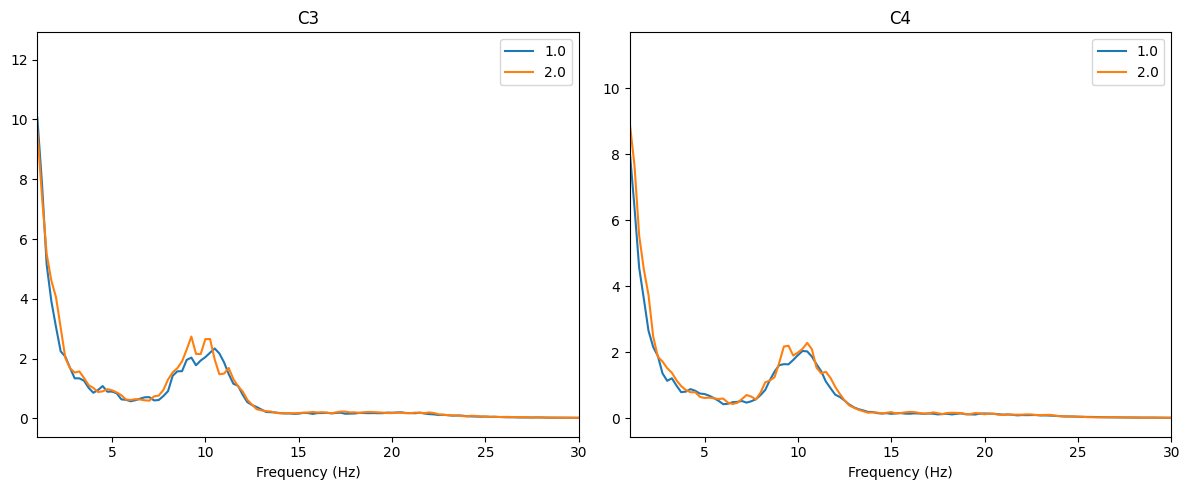

In [ ]:
plot_psd(
    trials_PSD,
    freqs,
    [ch_names.index(ch) for ch in ['C3', 'C4']],
    chan_lab=ch_names,
    maxy=None
)

A spike of mu activity can be seen on each channel for both classes. In both the channels(C3, C4),  the mu for the class label 1 is lower than for the class label 2

# Data Pre-processing

## Filtering

In [ ]:
# Creating a bandpass filter

def bandpass(trials, lo, hi, sample_rate):
    '''
    Designs and applies a bandpass filter to the signal.

    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEGsignal
    lo : float
        Lower frequency bound (in Hz)
    hi : float
        Upper frequency bound (in Hz)
    sample_rate : float
        Sample rate of the signal (in Hz)

    Returns
    -------
    trials_filt : 3d-array (channels x samples x trials)
        The bandpassed signal
    '''

    # The iirfilter() function takes the filter order: higher numbers mean a sharper frequency cutoff,
    # but the resulting signal might be shifted in time, lower numbers mean a soft frequency cutoff,
    # but the resulting signal less distorted in time. It also takes the lower and upper frequency bounds
    # to pass, divided by the nyquist frequency, which is the sample rate divided by 2:

    a, b = scipy.signal.iirfilter(6, [lo/(sample_rate/2.0), hi/(sample_rate/2.0)])

    # Applying the filter to each trial
    ntrials = trials.shape[2]
    trials_filt = np.zeros((nchannels, nsamples, ntrials))
    for i in range(ntrials):
        trials_filt[:,:,i] = scipy.signal.filtfilt(a, b, trials[:,:,i], axis=1)

    return trials_filt

In [ ]:
# Apply the function
trials_filt = {1.0: bandpass(trials[1.0], 8, 15, sample_rate),
               2.0: bandpass(trials[2.0], 8, 15, sample_rate)}

In [ ]:
print('Shape of filtered trials[1.0]:', trials_filt[1.0].shape)
print('Shape of filtered trials[2.0]:', trials_filt[2.0].shape)

Shape of filtered trials[1.0]: (2, 500, 149)
Shape of filtered trials[2.0]: (2, 500, 157)


Plotting the PSD of the resulting trials_filt shows the suppression of frequencies outside the passband of the filter

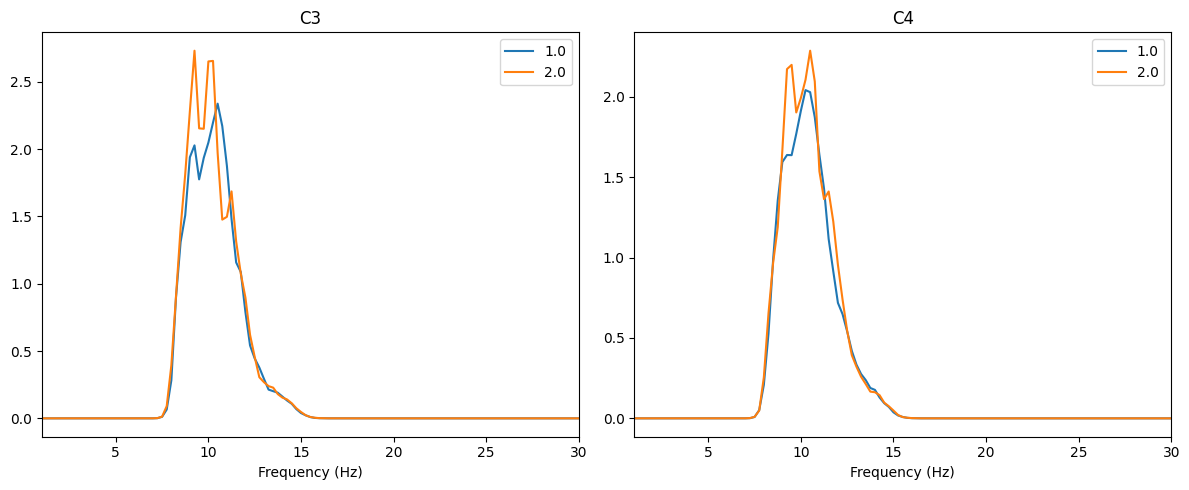

In [ ]:
psd_1, freqs = psd(trials_filt[1.0])
psd_2, freqs = psd(trials_filt[2.0])
trials_PSD = {1.0: psd_1, 2.0: psd_2}

plot_psd(
    trials_PSD,
    freqs,
    [ch_names.index(ch) for ch in ['C3', 'C4']],
    chan_lab=ch_names
)

## Referencing

In [ ]:
# Creating a Common Average Referencing function

def avg_ref(trials):
    '''
    Designs and applies the Common Average Referencing to the signal.

    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEGsignal

    Returns
    -------
    trials_car : 3d-array (channels x samples x trials)
        The refrenece adjusted signal
    '''

    # calculate the average across all channels
    trials_avg = np.mean(trials, axis=0)

    # Subtract the average from each channel
    trials_car = trials - trials_avg

    return trials_car

In [ ]:
# Apply the function
trials_car = {1.0: avg_ref(trials_filt[1.0]),
               2.0: avg_ref(trials_filt[2.0])}

In [ ]:
print('Shape of CAR trials[1.0]:', trials_car[1.0].shape)
print('Shape of CAR trials[2.0]:', trials_car[2.0].shape)

Shape of CAR trials[1.0]: (2, 500, 149)
Shape of CAR trials[2.0]: (2, 500, 157)


## Feature extraction

I am following a classic BCI design by Blankertz et al(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7604514/), where they use the logarithm of the variance of the signal in a certain frequency band as a feature for the classifier.

In [ ]:
# Calculate the log(var) of the trials

def logvar(trials):
    '''
    Calculate the log-var of each channel.

    Parameters
    ----------
    trials : 3d-array (channels x samples x trials)
        The EEG signal.

    Returns
    -------
    logvar - 2d-array (channels x trials)
        For each channel the logvar of the signal
    '''
    return np.log(np.var(trials, axis=1))

In [ ]:
# Apply the function
trials_logvar = {1.0: logvar(trials_filt[1.0]),
                 2.0: logvar(trials_filt[2.0])}

In [ ]:
print('Shape of log_var trials[1.0]:', trials_logvar[1.0].shape)
print('Shape of log_var trials[2.0]:', trials_logvar[2.0].shape)

Shape of log_var trials[1.0]: (2, 149)
Shape of log_var trials[2.0]: (2, 157)


In [ ]:
# Creating a function to visualize the logvar of each channel as a bar chart

def plot_logvar(trials):
    '''
    Plots the log-var of each channel/component.
    arguments:
        trials - Dictionary containing the trials (log-vars x trials) for 2 classes.
    '''
    plt.figure(figsize=(12,5))

    x0 = np.arange(nchannels)
    x1 = np.arange(nchannels) + 0.4

    y0 = np.mean(trials[1.0], axis=1)
    y1 = np.mean(trials[2.0], axis=1)

    plt.bar(x0, y0, width=0.5, color='b')
    plt.bar(x1, y1, width=0.4, color='r')

    plt.xlim(-0.5, nchannels+0.5)

    plt.gca().yaxis.grid(True)
    plt.title('log-var of each channel/component')
    plt.xlabel('channels/components')
    plt.ylabel('log-var')
    plt.legend([1.0, 2.0])

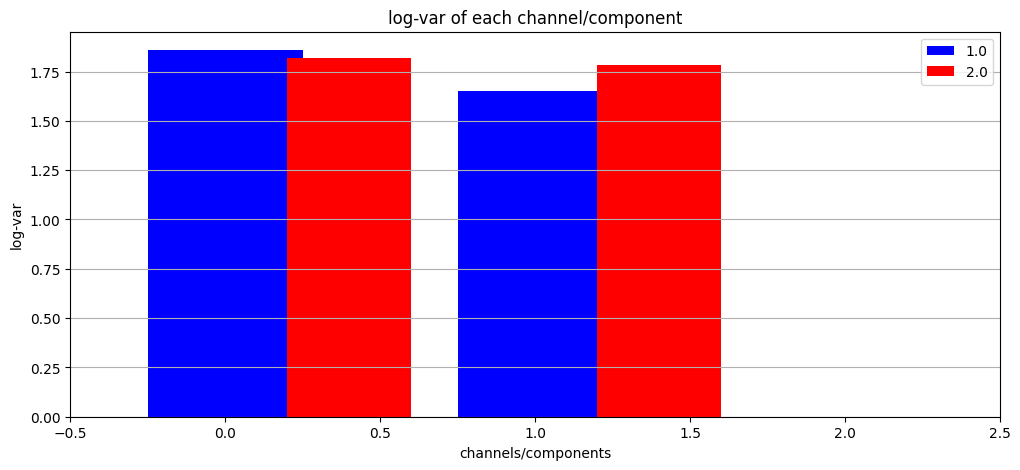

In [ ]:
# Plot the log-vars

plot_logvar(trials_logvar)

In cases where we have multiple channels, most channels show a small difference in the log-var of the signal between the two classes.

In such scenario we can apply the CSP algorithm to calculate mixture of channels that are designed to maximize the difference in variation between two classes. These mixures are called spatial filters.

Though, we only have 2 channels in this data but I am still applying the CSP algorithm to see its effect

In [ ]:
def cov(trials):
    ''' Calculate the covariance for each trial and return their average '''
    ntrials = trials.shape[2]
    covs = [ trials[:,:,i].dot(trials[:,:,i].T) / nsamples for i in range(ntrials) ]
    return np.mean(covs, axis=0)


def whitening(sigma):
    ''' Calculate a whitening matrix for covariance matrix sigma. '''
    U, l, _ = linalg.svd(sigma)
    return U.dot( np.diag(l ** -0.5) )


def csp(trials_r, trials_f):
    '''
    Calculate the CSP transformation matrix W.
    arguments:
        trials_r - Array (channels x samples x trials) containing right hand movement trials
        trials_f - Array (channels x samples x trials) containing foot movement trials
    returns:
        Mixing matrix W
    '''
    cov_r = cov(trials_r)
    cov_f = cov(trials_f)
    P = whitening(cov_r + cov_f)
    B, _, _ = linalg.svd( P.T.dot(cov_f).dot(P) )
    W = P.dot(B)
    return W


def apply_mix(W, trials):
    ''' Apply a mixing matrix to each trial (basically multiply W with the EEG signal matrix)'''
    ntrials = trials.shape[2]
    trials_csp = np.zeros((nchannels, nsamples, ntrials))
    for i in range(ntrials):
        trials_csp[:,:,i] = W.T.dot(trials[:,:,i])
    return trials_csp

In [ ]:
# Apply the functions

W = csp(trials_filt[1.0], trials_filt[2.0])

trials_csp = {1.0: apply_mix(W, trials_filt[1.0]),
              2.0: apply_mix(W, trials_filt[2.0])}

In [ ]:
print('Shape of csp trials[1.0]:', trials_csp[1.0].shape)
print('Shape of csp trials[2.0]:', trials_csp[2.0].shape)

Shape of csp trials[1.0]: (2, 500, 149)
Shape of csp trials[2.0]: (2, 500, 157)


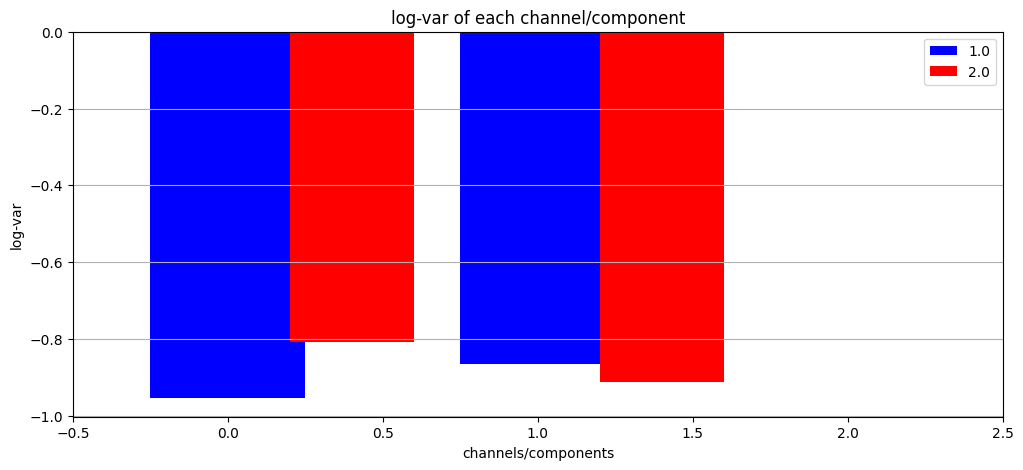

In [ ]:
# Plotting the CSP transformed trials data

trials_logvar_csp = {1.0: logvar(trials_csp[1.0]),
                     2.0: logvar(trials_csp[2.0])}

plot_logvar(trials_logvar_csp)

We now have mixtures of channels, called components. They are the result of 2 spatial filters applied to the data.

The first filter maximize the variation of the first class, while minimizing the variation of the second. The last filter maximize the variation of the second class, while minimizing the variation of the first.

## Visualization

In [ ]:
# Creating a function to visulaize the data as per the first and last component

def plot_scatter(X, Y):
    plt.figure()
    plt.scatter(X[0,:], X[-1,:], color='b')
    plt.scatter(Y[0,:], Y[-1,:], color='r')
    plt.xlabel('Last component')
    plt.ylabel('First component')
    plt.legend([1.0, 2.0])

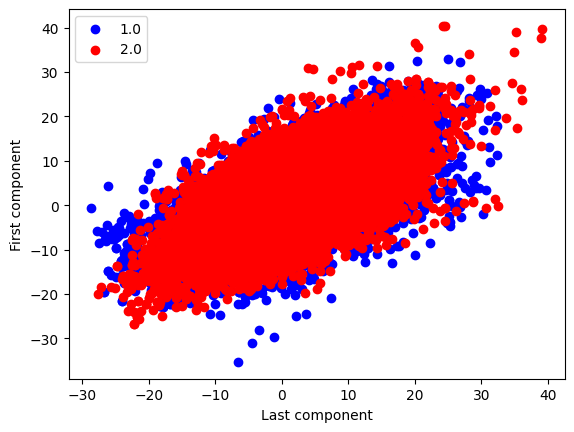

In [ ]:
# Using the original raw data

plot_scatter(trials[1.0], trials[2.0])

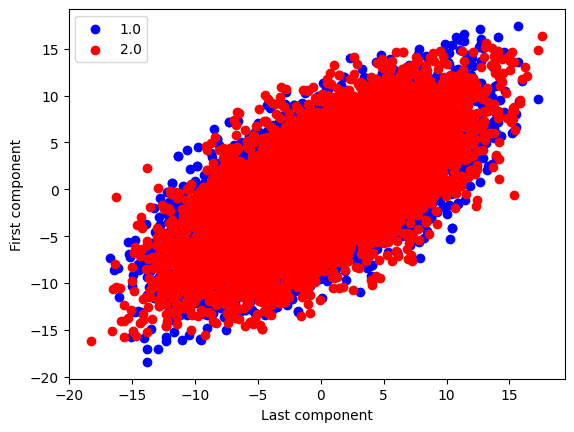

In [ ]:
# Using the band-pass filtered data

plot_scatter(trials_filt[1.0], trials_filt[2.0])

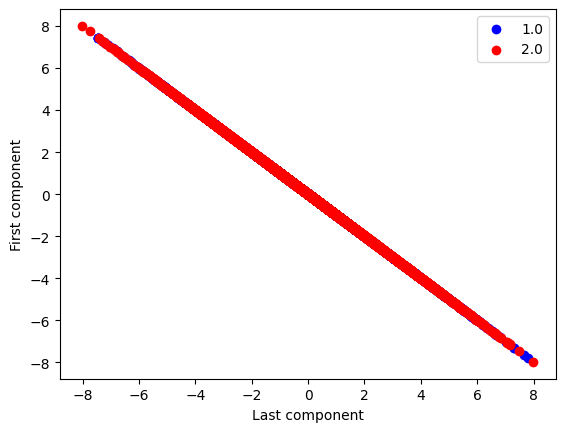

In [ ]:
# Using the band-pass filtered and CAR data

plot_scatter(trials_car[1.0], trials_car[2.0])

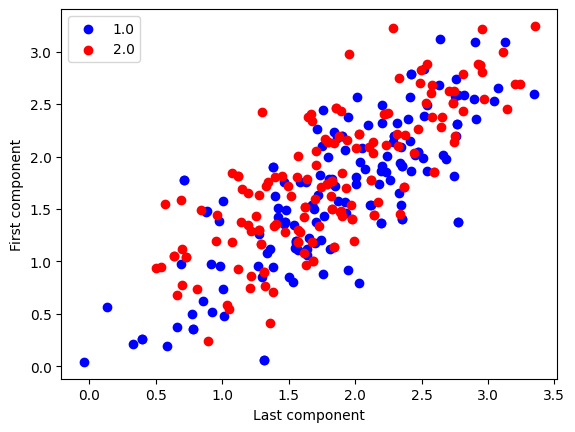

In [ ]:
# Using the extracted feature (log-var)

plot_scatter(trials_logvar[1.0], trials_logvar[2.0])

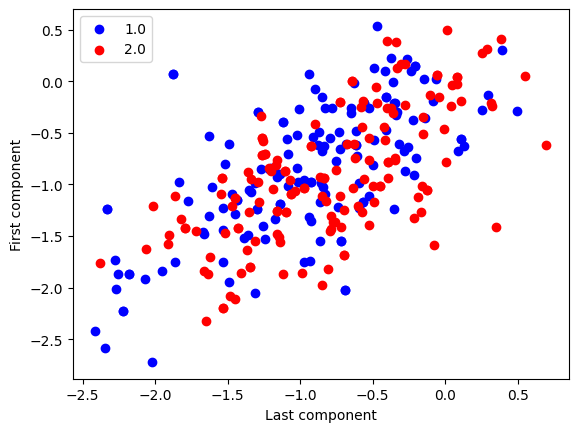

In [ ]:
# Using the CSP transfomed data

plot_scatter(trials_logvar_csp[1.0], trials_logvar_csp[2.0])

As observed with the original data, the class labels are highly overlapped, with the use of extracted feature (log-var), we observe significant seperation.

Further with CSP, there is not a significant improvement when compared to log-var as our data had only 2 channels

# Random Forest(RF) Classifier

## With Raw Data

### Preparing the training data

In [ ]:
print('Shape of trials[1.0]:', trials[1.0].shape)
print('Shape of trials[2.0]:', trials[2.0].shape)

Shape of trials[1.0]: (2, 500, 149)
Shape of trials[2.0]: (2, 500, 157)


The above is a 3D array, for RF we need data in 2D, hence we need to reshape

In [ ]:
trials_1_2d = trials[1.0].reshape(149, -1)
trials_2_2d = trials[2.0].reshape(157, -1)

In [ ]:
trials_1_2d.shape, trials_2_2d.shape

((149, 1000), (157, 1000))

In [ ]:
# Getting the training data

X_train_rf = np.concatenate([trials_1_2d, trials_2_2d])
X_train_rf.shape

(306, 1000)

In [ ]:
# Getting the list of all the training trials and corresponding labels

train_labels = pd.DataFrame(np.concatenate([cl_1, cl_2]), columns=['trial'], dtype=int)

train_labels = train_labels.merge(trial_df[['trial', 'label']], on='trial', how='left')

train_labels[:5]

,trial,label
0,6,1.0
1,14,1.0
2,17,1.0
3,19,1.0
4,22,1.0


In [ ]:
Y_train_rf = np.array(train_labels.label).astype('int')
Y_train_rf

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [ ]:
Y_train_rf.shape

(306,)

### Preparing the test data

In [ ]:
test_df.head()

,C3,C4,sample,trial,label
365179,9.130602,7.995420,365180,321.0,Test
365180,5.065878,5.858121,365181,321.0,Test
365181,2.380612,1.855070,365182,321.0,Test
365182,0.866716,-1.696417,365183,321.0,Test
365183,-0.829549,-2.611749,365184,321.0,Test


In [ ]:
# Checking the sample count in each trial

pd.pivot_table(test_df, index='trial', values='label', aggfunc='count').reset_index()

,trial,label
0,321.0,1128
1,322.0,1043
2,323.0,1077
3,326.0,1043
4,327.0,1175
...,...,...
146,635.0,1189
147,637.0,1097
148,638.0,1089
149,639.0,1050


For the last trial (640), we only have 957 samples, which means this is not a complete trial as the last sample should be more then 1000 (idx_end). This trial needs to be excluded

In [ ]:
# Initializing an empty dictionary, this will have 'Test' as key and trial data as values
test_trials ={'Test': None}


# Subsetting the data to exclude the last trial
l_df = test_df[test_df.trial!=640.0]

# Initializing a 3D array for the given label
ntrial = l_df['trial'].nunique()
test_trials['Test'] = np.zeros((nchannels, nsamples, ntrial))

# Getting the array of trial numbers for given label
trial_arr = l_df['trial'].unique()

# Iterating over the trials to fill in the array
for i, t in enumerate(trial_arr):

    # Subsetting the trial dataframe for given trial from the label dataframe
    t_df = l_df[l_df.trial==t]

    # Adding an index column
    t_df['idx'] = range(1, len(t_df) + 1)

    # Selecting the samples that fall within the visual cue time range and selecting only channel columns
    t_df = t_df[(t_df.idx>=idx_start) & (t_df.idx<idx_end)][ch_names]

    # Updating the dictionary
    test_trials['Test'][:,:,i] = t_df.T


In [ ]:
test_trials['Test'].shape

(2, 500, 150)

In [ ]:
# Re-shapping in 2D

X_test_rf = test_trials['Test'].reshape(150, -1)
X_test_rf.shape

(150, 1000)

In [ ]:
# Getting Y_test

true_labels = pd.read_excel("True labels_3b.xlsx")
true_labels

,test_trial,true_label
0,321,2
1,322,2
2,323,1
3,324,2
4,325,2
...,...,...
315,636,1
316,637,1
317,638,2
318,639,2


In [ ]:
# Excluding the trials that have null values and the last 640 trial

Y_test_rf = true_labels[true_labels['test_trial'].isin(test_df.trial.unique()[:-1])]
Y_test_rf

,test_trial,true_label
0,321,2
1,322,2
2,323,1
5,326,1
6,327,2
...,...,...
313,634,1
314,635,2
316,637,1
317,638,2


In [ ]:
Y_test_rf = np.array(Y_test_rf.true_label)
Y_test_rf

array([2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2,
       1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2,
       2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2,
       1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2,
       1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2,
       1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2])

In [ ]:
Y_test_rf.shape

(150,)

### Training the model

In [ ]:
# Create and train a Random Forest Classifier

rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_rf, Y_train_rf)

RandomForestClassifier(criterion='entropy', random_state=123)

### Testing the model

In [ ]:
# Make predictions
Y_pred_rf = rfc.predict(X_test_rf)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_rf, Y_pred_rf, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label,1,2
Actual label,,
1,27,43
2,35,45


In [ ]:
# Creating a dictionary to store model performance metrics

rf_mdl_1 = {}

rf_mdl_1['Accuracy'] = round(accuracy_score(Y_test_rf, Y_pred_rf)*100)
rf_mdl_1['Precision'] = round(precision_score(Y_test_rf, Y_pred_rf)*100)
rf_mdl_1['Recall'] = round(recall_score(Y_test_rf, Y_pred_rf)*100)
rf_mdl_1['F1_score'] = round(f1_score(Y_test_rf, Y_pred_rf)*100)

# Displaying the model performance metrics
rf_mdl_1

{'Accuracy': 48, 'Precision': 44, 'Recall': 39, 'F1_score': 41}

## With Filtered Data (band-pass)

### Preparing the training data

In [ ]:
print('Shape of filtered trials[1.0]:', trials_filt[1.0].shape)
print('Shape of filtered trials[2.0]:', trials_filt[2.0].shape)

Shape of filtered trials[1.0]: (2, 500, 149)
Shape of filtered trials[2.0]: (2, 500, 157)


The above is a 3D array, for RF we need data in 2D, hence we need to reshape

In [ ]:
trials_1_2d = trials_filt[1.0].reshape(149, -1)
trials_2_2d = trials_filt[2.0].reshape(157, -1)

In [ ]:
trials_1_2d.shape, trials_2_2d.shape

((149, 1000), (157, 1000))

In [ ]:
# Getting the training data

X_train_rf = np.concatenate([trials_1_2d, trials_2_2d])
X_train_rf.shape

(306, 1000)

In [ ]:
Y_train_rf.shape

(306,)

### Preparing the test data

In [ ]:
# Raw Test Data
test_trials['Test'].shape

(2, 500, 150)

In [ ]:
# Applying the band-pass filter

test_trials_filt = {'Test': bandpass(test_trials['Test'], 8, 15, sample_rate)}

In [ ]:
# Re-shapping in 2D

X_test_rf = test_trials_filt['Test'].reshape(150, -1)
X_test_rf.shape

(150, 1000)

In [ ]:
Y_test_rf.shape

(150,)

### Training the model

In [ ]:
# Create and train a Random Forest Classifier

rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_rf, Y_train_rf)

RandomForestClassifier(criterion='entropy', random_state=123)

### Testing the model

In [ ]:
# Make predictions
Y_pred_rf = rfc.predict(X_test_rf)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_rf, Y_pred_rf, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label,1,2
Actual label,,
1,29,41
2,40,40


In [ ]:
# Creating a dictionary to store model performance metrics

rf_mdl_2 = {}

rf_mdl_2['Accuracy'] = round(accuracy_score(Y_test_rf, Y_pred_rf)*100)
rf_mdl_2['Precision'] = round(precision_score(Y_test_rf, Y_pred_rf)*100)
rf_mdl_2['Recall'] = round(recall_score(Y_test_rf, Y_pred_rf)*100)
rf_mdl_2['F1_score'] = round(f1_score(Y_test_rf, Y_pred_rf)*100)

# Displaying the model performance metrics
rf_mdl_2

{'Accuracy': 46, 'Precision': 42, 'Recall': 41, 'F1_score': 42}

## With Referenced data (CAR)

### Preparing the training data

In [ ]:
print('Shape of referenced trials[1.0]:', trials_car[1.0].shape)
print('Shape of referenced trials[2.0]:', trials_car[2.0].shape)

Shape of referenced trials[1.0]: (2, 500, 149)
Shape of referenced trials[2.0]: (2, 500, 157)


The above is a 3D array, for RF we need data in 2D, hence we need to reshape

In [ ]:
trials_1_2d = trials_car[1.0].reshape(149, -1)
trials_2_2d = trials_car[2.0].reshape(157, -1)

In [ ]:
trials_1_2d.shape, trials_2_2d.shape

((149, 1000), (157, 1000))

In [ ]:
# Getting the training data

X_train_rf = np.concatenate([trials_1_2d, trials_2_2d])
X_train_rf.shape

(306, 1000)

In [ ]:
Y_train_rf.shape

(306,)

### Preparing the test data

In [ ]:
# Raw Test Data
test_trials_filt['Test'].shape

(2, 500, 150)

In [ ]:
# Applying the band-pass filter

test_trials_car = {'Test': avg_ref(test_trials_filt['Test'])}

In [ ]:
# Re-shapping in 2D

X_test_rf = test_trials_car['Test'].reshape(150, -1)
X_test_rf.shape

(150, 1000)

In [ ]:
Y_test_rf.shape

(150,)

### Training the model

In [ ]:
# Create and train a Random Forest Classifier

rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_rf, Y_train_rf)

RandomForestClassifier(criterion='entropy', random_state=123)

### Testing the model

In [ ]:
# Make predictions
Y_pred_rf = rfc.predict(X_test_rf)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_rf, Y_pred_rf, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label,1,2
Actual label,,
1,37,33
2,30,50


In [ ]:
# Creating a dictionary to store model performance metrics

rf_mdl_car = {}

rf_mdl_car['Accuracy'] = round(accuracy_score(Y_test_rf, Y_pred_rf)*100)
rf_mdl_car['Precision'] = round(precision_score(Y_test_rf, Y_pred_rf)*100)
rf_mdl_car['Recall'] = round(recall_score(Y_test_rf, Y_pred_rf)*100)
rf_mdl_car['F1_score'] = round(f1_score(Y_test_rf, Y_pred_rf)*100)

# Displaying the model performance metrics
rf_mdl_car

{'Accuracy': 58, 'Precision': 55, 'Recall': 53, 'F1_score': 54}

In [ ]:
# Displaying the model performance metrics
rf_mdl_2

{'Accuracy': 46, 'Precision': 42, 'Recall': 41, 'F1_score': 42}

In [ ]:
rf_mdl_1

{'Accuracy': 48, 'Precision': 44, 'Recall': 39, 'F1_score': 41}

## With Transformed Data: Logarithm of Variance (log-var)

### Preparing the training data

In [ ]:
print('Shape of log_var trials[1.0]:', trials_logvar[1.0].shape)
print('Shape of log_var trials[2.0]:', trials_logvar[2.0].shape)

Shape of log_var trials[1.0]: (2, 149)
Shape of log_var trials[2.0]: (2, 157)


In [ ]:
# Getting the training data

X_train_rf = np.concatenate([trials_logvar[1.0].T, trials_logvar[2.0].T])
X_train_rf.shape

(306, 2)

In [ ]:
Y_train_rf.shape

(306,)

### Preparing the test data

In [ ]:
# Band-pass filtered Data

test_trials_filt['Test'].shape

(2, 500, 150)

In [ ]:
# Performing the log-var transformation

test_trials_logvar = {'Test': logvar(test_trials_filt['Test'])}

In [ ]:
test_trials_logvar['Test'].shape

(2, 150)

In [ ]:
X_test_rf = test_trials_logvar['Test'].T
X_test_rf.shape

(150, 2)

In [ ]:
Y_test_rf.shape

(150,)

### Training the model

In [ ]:
# Create and train a Random Forest Classifier

rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_rf, Y_train_rf)

RandomForestClassifier(criterion='entropy', random_state=123)

### Testing the model

In [ ]:
# Make predictions
Y_pred_rf = rfc.predict(X_test_rf)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_rf, Y_pred_rf, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label,1,2
Actual label,,
1,38,32
2,45,35


In [ ]:
# Creating a dictionary to store model performance metrics

rf_mdl_3 = {}

rf_mdl_3['Accuracy'] = round(accuracy_score(Y_test_rf, Y_pred_rf)*100)
rf_mdl_3['Precision'] = round(precision_score(Y_test_rf, Y_pred_rf)*100)
rf_mdl_3['Recall'] = round(recall_score(Y_test_rf, Y_pred_rf)*100)
rf_mdl_3['F1_score'] = round(f1_score(Y_test_rf, Y_pred_rf)*100)

# Displaying the model performance metrics
rf_mdl_3

{'Accuracy': 49, 'Precision': 46, 'Recall': 54, 'F1_score': 50}

## With Transformed Data: Short-term Fourier transform (STFT)

### Preparing the training data

In [ ]:
print('Shape of filtered trials[1.0]:', trials_filt[1.0].shape)
print('Shape of filtered trials[2.0]:', trials_filt[2.0].shape)

Shape of filtered trials[1.0]: (2, 500, 149)
Shape of filtered trials[2.0]: (2, 500, 157)


In [ ]:
# Reshaping the data

x_1 = np.moveaxis(trials_filt[1.0], 0,2)
x_1 = np.moveaxis(x_1, 0,1)

x_2 = np.moveaxis(trials_filt[2.0], 0,2)
x_2 = np.moveaxis(x_2, 0,1)

x_1.shape, x_2.shape

((149, 500, 2), (157, 500, 2))

In [ ]:
# Creating the training data
data_array = np.vstack((x_1, x_2))
data_array.shape

(306, 500, 2)

Performing STFT

In [ ]:
# STFT parameters
fs = sample_rate # Sampling frequency
nperseg = nsamples  # Length of each segment
noverlap = 32  # Overlap between segments

fs, nperseg, noverlap

(125, 500, 32)

In [ ]:
# Perform STFT for each channel
stft_results = []
for channel in range(data_array.shape[2]):  # Iterate over channels
    channel_data = data_array[:, :, channel]  # Extract data for each channel
    _, _, stft_data = stft(channel_data, fs=fs, nperseg=nperseg, noverlap=noverlap)
    stft_results.append(stft_data)

# Convert the results to a NumPy array
stft_results = np.array(stft_results)
stft_results.shape

# The shape of 'stft_results' will be (channels, trials, frequency_bins, time_bins)

(2, 306, 251, 3)

In [ ]:
# Reshaping the data

X_train_rf = np.moveaxis(stft_results, 0,-1)
X_train_rf.shape

# Now the data is in shape: trials * frequency_bins * time_bins * channels

(306, 251, 3, 2)

In [ ]:
X_train_rf.sum()

(-0.07398463151303328-0.04206922469088489j)

In [ ]:
# Converting the complex number into real by taking the magnitude

X_train_rf = np.abs(X_train_rf)
X_train_rf.shape

(306, 251, 3, 2)

The above is a 4D array, for RF we need data in 2D, hence we need to reshape

In [ ]:
X_train_rf = X_train_rf.reshape(306, -1)
X_train_rf.shape

(306, 1506)

In [ ]:
Y_train_rf.shape

(306,)

### Preparing the test data

In [ ]:
# Raw Test Data
test_trials['Test'].shape

(2, 500, 150)

In [ ]:
# Applying the band-pass filter

test_trials_filt = {'Test': bandpass(test_trials['Test'], 8, 15, sample_rate)}
test_trials_filt['Test'].shape

(2, 500, 150)

In [ ]:
# Creating the testing data
data_array = np.moveaxis(test_trials_filt['Test'], 0,2)
data_array = np.moveaxis(data_array, 0,1)
data_array.shape

(150, 500, 2)

Performing STFT

In [ ]:
# STFT parameters
fs = sample_rate # Sampling frequency
nperseg = nsamples  # Length of each segment
noverlap = 32  # Overlap between segments

fs, nperseg, noverlap

(125, 500, 32)

In [ ]:
# Perform STFT for each channel
stft_results = []
for channel in range(data_array.shape[2]):  # Iterate over channels
    channel_data = data_array[:, :, channel]  # Extract data for each channel
    _, _, stft_data = stft(channel_data, fs=fs, nperseg=nperseg, noverlap=noverlap)
    stft_results.append(stft_data)

# Convert the results to a NumPy array
stft_results = np.array(stft_results)
stft_results.shape

# The shape of 'stft_results' will be (channels, trials, frequency_bins, time_bins)

(2, 150, 251, 3)

In [ ]:
# Reshaping the data

X_test_rf = np.moveaxis(stft_results, 0,-1)
X_test_rf.shape

# Now the data is in shape: trials * frequency_bins * time_bins * channels

(150, 251, 3, 2)

In [ ]:
X_test_rf.sum()

(-0.35841754676734466-0.06295525054745132j)

In [ ]:
# Converting the complex number into real by taking the magnitude

X_test_rf = np.abs(X_test_rf)
X_test_rf.shape

(150, 251, 3, 2)

The above is a 4D array, for RF we need data in 2D, hence we need to reshape

In [ ]:
X_test_rf = X_test_rf.reshape(150, -1)
X_test_rf.shape

(150, 1506)

In [ ]:
Y_test_rf.shape

(150,)

### Training the model

In [ ]:
# Create and train a Random Forest Classifier

rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy", random_state = 123)
rfc.fit(X_train_rf, Y_train_rf)

RandomForestClassifier(criterion='entropy', random_state=123)

### Testing the model

In [ ]:
# Make predictions
Y_pred_rf = rfc.predict(X_test_rf)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_rf, Y_pred_rf, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label,1,2
Actual label,,
1,45,25
2,34,46


In [ ]:
# Creating a dictionary to store model performance metrics

rf_mdl_4 = {}

rf_mdl_4['Accuracy'] = round(accuracy_score(Y_test_rf, Y_pred_rf)*100)
rf_mdl_4['Precision'] = round(precision_score(Y_test_rf, Y_pred_rf)*100)
rf_mdl_4['Recall'] = round(recall_score(Y_test_rf, Y_pred_rf)*100)
rf_mdl_4['F1_score'] = round(f1_score(Y_test_rf, Y_pred_rf)*100)

# Displaying the model performance metrics
rf_mdl_4

{'Accuracy': 61, 'Precision': 57, 'Recall': 64, 'F1_score': 60}

**Random Forest Models comparison**

In [ ]:
print("RF with raw data:", rf_mdl_1)
print("RF with flitered data:", rf_mdl_2)
print("RF with log-var transformed data:", rf_mdl_3)
print("RF with STFT transformed data:", rf_mdl_4)

RF with raw data: {'Accuracy': 48, 'Precision': 44, 'Recall': 39, 'F1_score': 41}
RF with flitered data: {'Accuracy': 46, 'Precision': 42, 'Recall': 41, 'F1_score': 42}
RF with log-var transformed data: {'Accuracy': 49, 'Precision': 46, 'Recall': 54, 'F1_score': 50}
RF with STFT transformed data: {'Accuracy': 61, 'Precision': 57, 'Recall': 64, 'F1_score': 60}


# Support Vector Machine(SVM) Classifier

## With Raw Data

### Preparing the training data

In [ ]:
print('Shape of trials[1.0]:', trials[1.0].shape)
print('Shape of trials[2.0]:', trials[2.0].shape)

Shape of trials[1.0]: (2, 500, 149)
Shape of trials[2.0]: (2, 500, 157)


The above is a 3D array, for SVM we need data in 2D, hence we need to reshape

In [ ]:
trials_1_2d = trials[1.0].reshape(149, -1)
trials_2_2d = trials[2.0].reshape(157, -1)

In [ ]:
trials_1_2d.shape, trials_2_2d.shape

((149, 1000), (157, 1000))

In [ ]:
# Getting the training data

X_train_svm = np.concatenate([trials_1_2d, trials_2_2d])
X_train_svm.shape

(306, 1000)

In [ ]:
Y_train_svm = Y_train_rf.copy()
Y_train_svm.shape

(306,)

### Preparing the test data

In [ ]:
test_trials['Test'].shape

(2, 500, 150)

In [ ]:
# Re-shapping in 2D

X_test_svm = test_trials['Test'].reshape(150, -1)
X_test_svm.shape

(150, 1000)

In [ ]:
Y_test_svm = Y_test_rf.copy()
Y_test_svm.shape

(150,)

### Training the model

In [ ]:
# Create and train a SVM Classifier
svmc = SVC(kernel='rbf', random_state=42)  # RBF kernel can handle non-linear decision boundaries.
svmc.fit(X_train_svm, Y_train_svm)

SVC(random_state=42)

### Testing the model

In [ ]:
# Make predictions
Y_pred_svm = svmc.predict(X_test_svm)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_svm, Y_pred_svm, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label,1,2
Actual label,,
1,27,43
2,22,58


In [ ]:
# Creating a dictionary to store model performance metrics

svm_mdl_1 = {}

svm_mdl_1['Accuracy'] = round(accuracy_score(Y_test_svm, Y_pred_svm)*100)
svm_mdl_1['Precision'] = round(precision_score(Y_test_svm, Y_pred_svm)*100)
svm_mdl_1['Recall'] = round(recall_score(Y_test_svm, Y_pred_svm)*100)
svm_mdl_1['F1_score'] = round(f1_score(Y_test_svm, Y_pred_svm)*100)

# Displaying the model performance metrics
svm_mdl_1

{'Accuracy': 57, 'Precision': 55, 'Recall': 39, 'F1_score': 45}

## With Filtered Data (band-pass)

### Preparing the training data

In [ ]:
print('Shape of filtered trials[1.0]:', trials_filt[1.0].shape)
print('Shape of filtered trials[2.0]:', trials_filt[2.0].shape)

Shape of filtered trials[1.0]: (2, 500, 149)
Shape of filtered trials[2.0]: (2, 500, 157)


The above is a 3D array, for RF we need data in 2D, hence we need to reshape

In [ ]:
trials_1_2d = trials_filt[1.0].reshape(149, -1)
trials_2_2d = trials_filt[2.0].reshape(157, -1)

In [ ]:
trials_1_2d.shape, trials_2_2d.shape

((149, 1000), (157, 1000))

In [ ]:
# Getting the training data

X_train_svm = np.concatenate([trials_1_2d, trials_2_2d])
X_train_svm.shape

(306, 1000)

In [ ]:
Y_train_svm.shape

(306,)

### Preparing the test data

In [ ]:
# Raw Test Data
test_trials['Test'].shape

(2, 500, 150)

In [ ]:
# Applying the band-pass filter

test_trials_filt = {'Test': bandpass(test_trials['Test'], 8, 15, sample_rate)}

In [ ]:
# Re-shapping in 2D

X_test_svm = test_trials_filt['Test'].reshape(150, -1)
X_test_svm.shape

(150, 1000)

In [ ]:
Y_test_svm.shape

(150,)

### Training the model

In [ ]:
# Create and train a SVM Classifier
svmc = SVC(kernel='rbf', random_state=42)  # RBF kernel can handle non-linear decision boundaries.
svmc.fit(X_train_svm, Y_train_svm)

SVC(random_state=42)

### Testing the model

In [ ]:
# Make predictions
Y_pred_svm = svmc.predict(X_test_svm)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_svm, Y_pred_svm, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label,1,2
Actual label,,
1,21,49
2,24,56


In [ ]:
# Creating a dictionary to store model performance metrics

svm_mdl_2 = {}

svm_mdl_2['Accuracy'] = round(accuracy_score(Y_test_svm, Y_pred_svm)*100)
svm_mdl_2['Precision'] = round(precision_score(Y_test_svm, Y_pred_svm)*100)
svm_mdl_2['Recall'] = round(recall_score(Y_test_svm, Y_pred_svm)*100)
svm_mdl_2['F1_score'] = round(f1_score(Y_test_svm, Y_pred_svm)*100)

# Displaying the model performance metrics
svm_mdl_2

{'Accuracy': 51, 'Precision': 47, 'Recall': 30, 'F1_score': 37}

## With Referenced data (CAR)

### Preparing the training data

In [ ]:
print('Shape of referenced trials[1.0]:', trials_car[1.0].shape)
print('Shape of referenced trials[2.0]:', trials_car[2.0].shape)

Shape of referenced trials[1.0]: (2, 500, 149)
Shape of referenced trials[2.0]: (2, 500, 157)


The above is a 3D array, for RF we need data in 2D, hence we need to reshape

In [ ]:
trials_1_2d = trials_car[1.0].reshape(149, -1)
trials_2_2d = trials_car[2.0].reshape(157, -1)

In [ ]:
trials_1_2d.shape, trials_2_2d.shape

((149, 1000), (157, 1000))

In [ ]:
# Getting the training data

X_train_svm = np.concatenate([trials_1_2d, trials_2_2d])
X_train_svm.shape

(306, 1000)

In [ ]:
Y_train_svm.shape

(306,)

### Preparing the test data

In [ ]:
# Raw Test Data
test_trials_filt['Test'].shape

(2, 500, 150)

In [ ]:
# Applying the band-pass filter

test_trials_car = {'Test': avg_ref(test_trials_filt['Test'])}

In [ ]:
# Re-shapping in 2D

X_test_svm = test_trials_filt['Test'].reshape(150, -1)
X_test_svm.shape

(150, 1000)

In [ ]:
Y_test_svm.shape

(150,)

### Training the model

In [ ]:
# Create and train a SVM Classifier
svmc = SVC(kernel='rbf', random_state=42)  # RBF kernel can handle non-linear decision boundaries.
svmc.fit(X_train_svm, Y_train_svm)

SVC(random_state=42)

### Testing the model

In [ ]:
# Make predictions
Y_pred_svm = svmc.predict(X_test_svm)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_svm, Y_pred_svm, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label,1,2
Actual label,,
1,3,67
2,4,76


In [ ]:
# Creating a dictionary to store model performance metrics

svm_mdl_car = {}

svm_mdl_car['Accuracy'] = round(accuracy_score(Y_test_svm, Y_pred_svm)*100)
svm_mdl_car['Precision'] = round(precision_score(Y_test_svm, Y_pred_svm)*100)
svm_mdl_car['Recall'] = round(recall_score(Y_test_svm, Y_pred_svm)*100)
svm_mdl_car['F1_score'] = round(f1_score(Y_test_svm, Y_pred_svm)*100)

# Displaying the model performance metrics
svm_mdl_car

{'Accuracy': 53, 'Precision': 43, 'Recall': 4, 'F1_score': 8}

In [ ]:
# Displaying the model performance metrics
svm_mdl_2

{'Accuracy': 51, 'Precision': 47, 'Recall': 30, 'F1_score': 37}

## With Transformed Data: Logarithm of Variance (log-var)

### Preparing the training data

In [ ]:
print('Shape of log_var trials[1.0]:', trials_logvar[1.0].shape)
print('Shape of log_var trials[2.0]:', trials_logvar[2.0].shape)

Shape of log_var trials[1.0]: (2, 149)
Shape of log_var trials[2.0]: (2, 157)


In [ ]:
# Getting the training data

X_train_svm = np.concatenate([trials_logvar[1.0].T, trials_logvar[2.0].T])
X_train_svm.shape

(306, 2)

In [ ]:
Y_train_svm.shape

(306,)

### Preparing the test data

In [ ]:
# Band-pass filtered Data

test_trials_filt['Test'].shape

(2, 500, 150)

In [ ]:
# Performing the log-var transformation

test_trials_logvar = {'Test': logvar(test_trials_filt['Test'])}

In [ ]:
test_trials_logvar['Test'].shape

(2, 150)

In [ ]:
X_test_svm = test_trials_logvar['Test'].T
X_test_svm.shape

(150, 2)

In [ ]:
Y_test_svm.shape

(150,)

### Training the model

In [ ]:
# Create and train a SVM Classifier
svmc = SVC(kernel='rbf', random_state=42)  # RBF kernel can handle non-linear decision boundaries.
svmc.fit(X_train_svm, Y_train_svm)

SVC(random_state=42)

### Testing the model

In [ ]:
# Make predictions
Y_pred_svm = svmc.predict(X_test_svm)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_svm, Y_pred_svm, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label,1,2
Actual label,,
1,37,33
2,30,50


In [ ]:
# Creating a dictionary to store model performance metrics

svm_mdl_3 = {}

svm_mdl_3['Accuracy'] = round(accuracy_score(Y_test_svm, Y_pred_svm)*100)
svm_mdl_3['Precision'] = round(precision_score(Y_test_svm, Y_pred_svm)*100)
svm_mdl_3['Recall'] = round(recall_score(Y_test_svm, Y_pred_svm)*100)
svm_mdl_3['F1_score'] = round(f1_score(Y_test_svm, Y_pred_svm)*100)

# Displaying the model performance metrics
svm_mdl_3

{'Accuracy': 58, 'Precision': 55, 'Recall': 53, 'F1_score': 54}

## With Transformed Data: Short-term Fourier transform (STFT)

### Preparing the training data

In [ ]:
print('Shape of filtered trials[1.0]:', trials_filt[1.0].shape)
print('Shape of filtered trials[2.0]:', trials_filt[2.0].shape)

Shape of filtered trials[1.0]: (2, 500, 149)
Shape of filtered trials[2.0]: (2, 500, 157)


In [ ]:
# Reshaping the data

x_1 = np.moveaxis(trials_filt[1.0], 0,2)
x_1 = np.moveaxis(x_1, 0,1)

x_2 = np.moveaxis(trials_filt[2.0], 0,2)
x_2 = np.moveaxis(x_2, 0,1)

x_1.shape, x_2.shape

((149, 500, 2), (157, 500, 2))

In [ ]:
# Creating the training data
data_array = np.vstack((x_1, x_2))
data_array.shape

(306, 500, 2)

Performing STFT

In [ ]:
# STFT parameters
fs = sample_rate # Sampling frequency
nperseg = nsamples  # Length of each segment
noverlap = 32  # Overlap between segments

fs, nperseg, noverlap

(125, 500, 32)

In [ ]:
# Perform STFT for each channel
stft_results = []
for channel in range(data_array.shape[2]):  # Iterate over channels
    channel_data = data_array[:, :, channel]  # Extract data for each channel
    _, _, stft_data = stft(channel_data, fs=fs, nperseg=nperseg, noverlap=noverlap)
    stft_results.append(stft_data)

# Convert the results to a NumPy array
stft_results = np.array(stft_results)
stft_results.shape

# The shape of 'stft_results' will be (channels, trials, frequency_bins, time_bins)

(2, 306, 251, 3)

In [ ]:
# Reshaping the data

X_train_svm = np.moveaxis(stft_results, 0,-1)
X_train_svm.shape

# Now the data is in shape: trials * frequency_bins * time_bins * channels

(306, 251, 3, 2)

In [ ]:
X_train_svm.sum()

(-0.07398463151303328-0.04206922469088489j)

In [ ]:
# Converting the complex number into real by taking the magnitude

X_train_svm = np.abs(X_train_svm)
X_train_svm.shape

(306, 251, 3, 2)

The above is a 4D array, for RF we need data in 2D, hence we need to reshape

In [ ]:
X_train_svm = X_train_svm.reshape(306, -1)
X_train_svm.shape

(306, 1506)

In [ ]:
Y_train_svm.shape

(306,)

### Preparing the test data

In [ ]:
# Raw Test Data
test_trials['Test'].shape

(2, 500, 150)

In [ ]:
# Applying the band-pass filter

test_trials_filt = {'Test': bandpass(test_trials['Test'], 8, 15, sample_rate)}
test_trials_filt['Test'].shape

(2, 500, 150)

In [ ]:
# Creating the testing data
data_array = np.moveaxis(test_trials_filt['Test'], 0,2)
data_array = np.moveaxis(data_array, 0,1)
data_array.shape

(150, 500, 2)

Performing STFT

In [ ]:
# STFT parameters
fs = sample_rate # Sampling frequency
nperseg = nsamples  # Length of each segment
noverlap = 32  # Overlap between segments

fs, nperseg, noverlap

(125, 500, 32)

In [ ]:
# Perform STFT for each channel
stft_results = []
for channel in range(data_array.shape[2]):  # Iterate over channels
    channel_data = data_array[:, :, channel]  # Extract data for each channel
    _, _, stft_data = stft(channel_data, fs=fs, nperseg=nperseg, noverlap=noverlap)
    stft_results.append(stft_data)

# Convert the results to a NumPy array
stft_results = np.array(stft_results)
stft_results.shape

# The shape of 'stft_results' will be (channels, trials, frequency_bins, time_bins)

(2, 150, 251, 3)

In [ ]:
# Reshaping the data

X_test_svm = np.moveaxis(stft_results, 0,-1)
X_test_svm.shape

# Now the data is in shape: trials * frequency_bins * time_bins * channels

(150, 251, 3, 2)

In [ ]:
X_test_svm.sum()

(-0.35841754676734466-0.06295525054745132j)

In [ ]:
# Converting the complex number into real by taking the magnitude

X_test_svm = np.abs(X_test_svm)
X_test_svm.shape

(150, 251, 3, 2)

The above is a 4D array, for RF we need data in 2D, hence we need to reshape

In [ ]:
X_test_svm = X_test_svm.reshape(150, -1)
X_test_svm.shape

(150, 1506)

In [ ]:
Y_test_svm.shape

(150,)

### Training the model

In [ ]:
# Create and train a SVM Classifier
svmc = SVC(kernel='rbf', random_state=42)  # RBF kernel can handle non-linear decision boundaries.
svmc.fit(X_train_svm, Y_train_svm)

SVC(random_state=42)

### Testing the model

In [ ]:
# Make predictions
Y_pred_svm = svmc.predict(X_test_svm)

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_svm, Y_pred_svm, rownames=['Actual label'], colnames=['Predicted label'])

Predicted label,1,2
Actual label,,
1,49,21
2,15,65


In [ ]:
# Creating a dictionary to store model performance metrics

svm_mdl_4 = {}

svm_mdl_4['Accuracy'] = round(accuracy_score(Y_test_svm, Y_pred_svm)*100)
svm_mdl_4['Precision'] = round(precision_score(Y_test_svm, Y_pred_svm)*100)
svm_mdl_4['Recall'] = round(recall_score(Y_test_svm, Y_pred_svm)*100)
svm_mdl_4['F1_score'] = round(f1_score(Y_test_svm, Y_pred_svm)*100)

# Displaying the model performance metrics
svm_mdl_4

{'Accuracy': 76, 'Precision': 77, 'Recall': 70, 'F1_score': 73}

**SVM Models comparison**

In [ ]:
print("SVM with raw data:", svm_mdl_1)
print("SVM with flitered data:", svm_mdl_2)
print("SVM with log-var transformed data:", svm_mdl_3)
print("SVM with STFT transformed data:", svm_mdl_4)

SVM with raw data: {'Accuracy': 57, 'Precision': 55, 'Recall': 39, 'F1_score': 45}
SVM with flitered data: {'Accuracy': 51, 'Precision': 47, 'Recall': 30, 'F1_score': 37}
SVM with log-var transformed data: {'Accuracy': 58, 'Precision': 55, 'Recall': 53, 'F1_score': 54}
SVM with STFT transformed data: {'Accuracy': 76, 'Precision': 77, 'Recall': 70, 'F1_score': 73}


# CNN Classifier

https://towardsdatascience.com/convolution-neural-network-e9b864ac1e6c

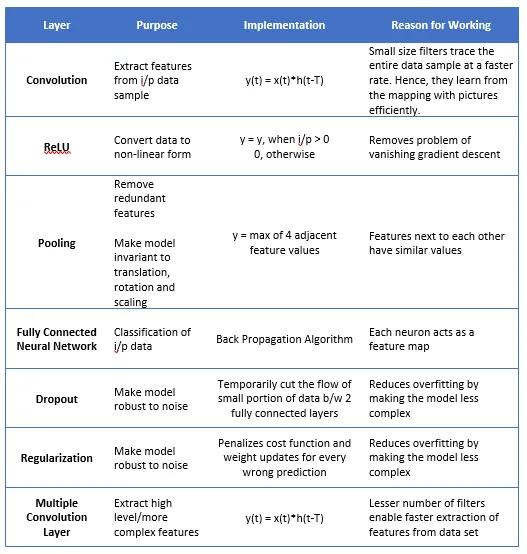

## With Raw Data

### Preparing the training data

In [ ]:
# Original training trials data

print('Shape of trials[1.0]:', trials[1.0].shape)
print('Shape of trials[2.0]:', trials[2.0].shape)

Shape of trials[1.0]: (2, 500, 149)
Shape of trials[2.0]: (2, 500, 157)


CNN's are generally used for image tasks, and the norm is that input data has shape: samples x sequence_length x features.

If we take this analogy, then for our EEG data, we can consider the 2 channels as features and they should be at the end

In [ ]:
# Reshaping the data

x_1 = np.moveaxis(trials[1.0], 0,2)
x_1 = np.moveaxis(x_1, 0,1)

x_2 = np.moveaxis(trials[2.0], 0,2)
x_2 = np.moveaxis(x_2, 0,1)

x_1.shape, x_2.shape

((149, 500, 2), (157, 500, 2))

In [ ]:
X_train_cnn = np.vstack((x_1, x_2))
X_train_cnn.shape

(306, 500, 2)

In [ ]:
# Minimum and Maximum values

X_train_cnn.min(), X_train_cnn.max()

(-35.289093, 40.392062)

Data normalization is a best practice in deep learning, as it helps improve training stability, convergence speed, and the overall performance of CNN

In [ ]:
# Normalizing the data

min_value = np.min(X_train_cnn)
max_value = np.max(X_train_cnn)
X_train_cnn_nrm = (X_train_cnn - min_value) / (max_value - min_value)

X_train_cnn_nrm.min(), X_train_cnn_nrm.max()

(0.0, 1.0)

In [ ]:
# Getting train labels

Y_train_cnn = Y_train_rf.reshape(Y_train_rf.shape[0], 1)
Y_train_cnn.shape

(306, 1)

In [ ]:
np.unique(Y_train_cnn)

array([1, 2])

As its a binary classifier, we will change the labels to 0 & 1

In [ ]:
# Re-mapping class labels

Y_train_cnn = Y_train_cnn - 1
np.unique(Y_train_cnn)

array([0, 1])

### Preparing the testing data

In [ ]:
# Original testing trials data

test_trials['Test'].shape

(2, 500, 150)

In [ ]:
# Reshaping the data

X_test_cnn = np.moveaxis(test_trials['Test'], 0,2)
X_test_cnn = np.moveaxis(X_test_cnn, 0,1)
X_test_cnn.shape

(150, 500, 2)

In [ ]:
# Normalizing the data

X_test_cnn_nrm = (X_test_cnn - min_value) / (max_value - min_value)

X_test_cnn_nrm.min(), X_test_cnn_nrm.max()

(-0.02227418437258256, 0.9885504654362105)

In [ ]:
# Getting test labels

Y_test_cnn = Y_test_rf.reshape(Y_test_rf.shape[0], 1)
Y_test_cnn.shape

(150, 1)

In [ ]:
np.unique(Y_test_cnn)

array([1, 2])

In [ ]:
# Re-mapping class labels

Y_test_cnn = Y_test_cnn - 1
np.unique(Y_test_cnn)

array([0, 1])

### Training the model

In [ ]:
# Getting the input shape

_, h, w = X_train_cnn.shape
h,w

(500, 2)

In [ ]:
# Setting the random seed for NumPy & Tensorflow to ensure result reproducibility

np.random.seed(1)
tf.random.set_seed(2)

In [ ]:
# Creating a CNN model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(h, w)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 498, 64)           448       
                                                                 
 conv1d_1 (Conv1D)           (None, 496, 64)           12352     
                                                                 
 dropout (Dropout)           (None, 496, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 248, 64)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 15872)             0         
                                                                 
 dense (Dense)               (None, 100)               1587300   
                                                        

In [ ]:
# hyper-parameters

epochs = 10
Optimizer = 'Adam'

In [ ]:
# Compiling the model

model.compile(optimizer=Optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
history = model.fit(X_train_cnn_nrm, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn_nrm, Y_test_cnn))

Epoch 1/10
10/10 [==============================] - 2s 107ms/step - loss: 0.8716 - accuracy: 0.5229 - val_loss: 0.7139 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 2/10
10/10 [==============================] - 1s 89ms/step - loss: 0.7240 - accuracy: 0.4967 - val_loss: 0.6917 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 3/10
10/10 [==============================] - 1s 91ms/step - loss: 0.6957 - accuracy: 0.5131 - val_loss: 0.6910 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 4/10
10/10 [==============================] - 1s 88ms/step - loss: 0.6931 - accuracy: 0.5131 - val_loss: 0.6924 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 5/10
10/10 [==============================] - 1s 86ms/step - loss: 0.6941 - accuracy: 0.5131 - val_loss: 0.6930 - val_accuracy: 0.5400 - lr: 0.0010
Epoch 6/10
10/10 [==============================] - 1s 80ms/step - loss: 0.6945 - accuracy: 0.5000 - val_loss: 0.6935 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 7/10
10/10 [==============================] - 1s 141ms/step - loss: 0

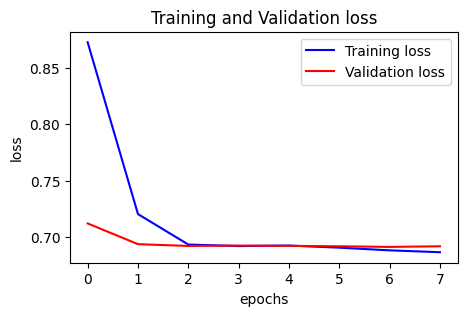

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = model.predict(X_test_cnn_nrm)
Y_pred_cnn = (pred_prob > 0.5).astype('int')

5/5 [==============================] - 0s 32ms/step


In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_cnn.reshape(-1), Y_pred_cnn.reshape(-1), rownames=['Actual label'], colnames=['Predicted label'])

Predicted label,0,1
Actual label,,
0,11,59
1,17,63


In [ ]:
# Creating a dictionary to store model performance metrics

cnn_mdl_1 = {}

cnn_mdl_1['Accuracy'] = round(accuracy_score(Y_test_cnn, Y_pred_cnn)*100)
cnn_mdl_1['Precision'] = round(precision_score(Y_test_cnn, Y_pred_cnn)*100)
cnn_mdl_1['Recall'] = round(recall_score(Y_test_cnn, Y_pred_cnn)*100)
cnn_mdl_1['F1_score'] = round(f1_score(Y_test_cnn, Y_pred_cnn)*100)

# Displaying the model performance metrics
cnn_mdl_1

{'Accuracy': 49, 'Precision': 52, 'Recall': 79, 'F1_score': 62}

#### Optimal probability cut-off

In [ ]:
# Creating a function to calculate various model performance metrics (sensivity, specificity etc.) for a given probablity cut-off

def perf_metrics(cut_off, Y_test, pred_prob):

  # Getting the class labels
  false_class , true_class = np.sort(np.unique(Y_test))

  # Creating a dataframe with actual and predcited Y
  df = pd.DataFrame()
  df['Y_actual'] = Y_test
  df['pred_prob'] = pred_prob
  df['Y_pred'] = list(map(lambda x: true_class if x > cut_off else false_class, df.pred_prob))

  # Calculating TP, TN, FP & FN
  df['TP'] = list(map(lambda x,y: 1 if x==y==true_class else 0, df.Y_actual, df.Y_pred))
  df['TN'] = list(map(lambda x,y: 1 if x==y==false_class else 0, df.Y_actual, df.Y_pred))
  df['FP'] = list(map(lambda x,y: 1 if ((x==false_class) & (y==true_class)) else 0, df.Y_actual, df.Y_pred))
  df['FN'] = list(map(lambda x,y: 1 if ((x==true_class) & (y==false_class)) else 0, df.Y_actual, df.Y_pred))

  TP = sum(df.TP)
  TN = sum(df.TN)
  FP = sum(df.FP)
  FN = sum(df.FN)

  # Calculating model performance metrics
  try:
    sensitivity = TP/(TP+FN)
  except:
    sensitivity = 0

  TPR = recall = sensitivity

  try:
    specificity = TN/(TN+FP)
  except:
    specificity = 0

  try:
    precision = TP/(TP+FP)
  except:
    precision = 0

  try:
    F_measure = (2*precision*recall)/(precision+recall)
  except:
    F_measure = 0

  try:
    FPR = 1 - specificity
  except:
    FPR = 0

  return sensitivity, specificity, precision, F_measure, TPR, FPR


In [ ]:
def opt_prob(cut_off_prob, Y_test, pred_prob):
  sensitivity=[]
  specificity=[]
  precision=[]
  F_measure=[]
  TPR=[]
  FPR=[]

  # Iterating over different cut-off probabilities and calculating the performance metrics
  for p in cut_off_prob:
    sen, spe, pre, fsc, tpr, fpr = perf_metrics(p, Y_test, pred_prob)
    sensitivity.append(sen)
    specificity.append(spe)
    precision.append(pre)
    F_measure.append(fsc)
    TPR.append(tpr)
    FPR.append(fpr)

  return sensitivity, specificity, TPR, FPR

In [ ]:
# Make predictions on the test set

y_pred_probabilities = model.predict(X_test_cnn_nrm)

5/5 [==============================] - 0s 16ms/step


In [ ]:
# Calculating sensitivity and specificity for different probability cut-offs

cut_off_prob = np.linspace(0,1,50)

sensitivity, specificity, TPR, FPR = opt_prob(cut_off_prob, Y_test_cnn.reshape(-1), y_pred_probabilities)

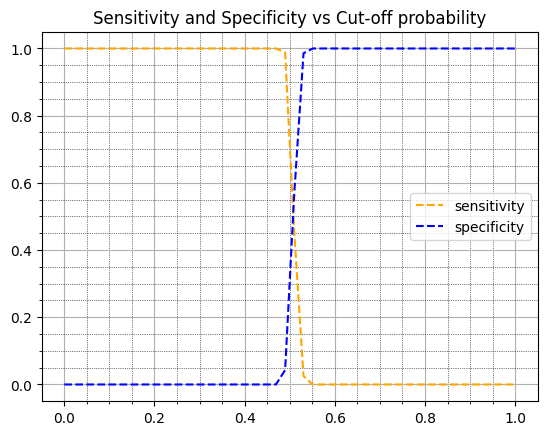

In [ ]:
# Plotting sensitivity and specificity to identify the optimal cut-off

sns.lineplot(x=cut_off_prob, y=sensitivity, color='orange', linestyle='--', label='sensitivity').minorticks_on()
sns.lineplot(x=cut_off_prob, y=specificity, color='blue', linestyle='--', label='specificity').grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title("Sensitivity and Specificity vs Cut-off probability")
plt.grid()
plt.show()

Optimal probability cutoff is ~0.55

In [ ]:
prob_cut_off = 0.5

# Convert probabilities to class labels
Y_pred_cnn = (y_pred_probabilities > prob_cut_off).astype(int)


np.unique(Y_pred_cnn)

array([0, 1])

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_cnn.reshape(-1), Y_pred_cnn.reshape(-1), rownames=['Actual label'], colnames=['Predicted label'])

Predicted label,0,1
Actual label,,
0,11,59
1,17,63


In [ ]:
# Calculating the performance metrics

print("Accuracy:", round(accuracy_score(Y_test_cnn, Y_pred_cnn)*100),"%")

print("\nPrecision:", round(precision_score(Y_test_cnn, Y_pred_cnn)*100),"%")

print("\nRecall:", round(recall_score(Y_test_cnn, Y_pred_cnn)*100),"%")

print("\nF1_score:", round(f1_score(Y_test_cnn, Y_pred_cnn)*100),"%")

Accuracy: 49 %

Precision: 52 %

Recall: 79 %

F1_score: 62 %


In [ ]:
cnn_mdl_1

{'Accuracy': 49, 'Precision': 52, 'Recall': 79, 'F1_score': 62}

## With Filtered Data (band-pass)

### Preparing the training data

In [ ]:
print('Shape of filtered trials[1.0]:', trials_filt[1.0].shape)
print('Shape of filtered trials[2.0]:', trials_filt[2.0].shape)

Shape of filtered trials[1.0]: (2, 500, 149)
Shape of filtered trials[2.0]: (2, 500, 157)


CNN's are generally used for image tasks, and the norm is that input data has shape: samples x sequence_length x features.

If we take this analogy, then for our EEG data, we can consider the 2 channels as features and they should be at the end

In [ ]:
# Reshaping the data

x_1 = np.moveaxis(trials_filt[1.0], 0,2)
x_1 = np.moveaxis(x_1, 0,1)

x_2 = np.moveaxis(trials_filt[2.0], 0,2)
x_2 = np.moveaxis(x_2, 0,1)

x_1.shape, x_2.shape

((149, 500, 2), (157, 500, 2))

In [ ]:
X_train_cnn = np.vstack((x_1, x_2))
X_train_cnn.shape

(306, 500, 2)

In [ ]:
# Minimum and Maximum values

X_train_cnn.min(), X_train_cnn.max()

(-18.40416822978628, 17.588101355206373)

Data normalization is a best practice in deep learning, as it helps improve training stability, convergence speed, and the overall performance of CNN

In [ ]:
# Normalizing the data

min_value = np.min(X_train_cnn)
max_value = np.max(X_train_cnn)
X_train_cnn_nrm = (X_train_cnn - min_value) / (max_value - min_value)

X_train_cnn_nrm.min(), X_train_cnn_nrm.max()

(0.0, 1.0)

In [ ]:
# Getting train labels

Y_train_cnn.shape

(306, 1)

In [ ]:
np.unique(Y_train_cnn)

array([0, 1])

### Preparing the testing data

In [ ]:
# Raw Test Data
test_trials['Test'].shape

# Applying the band-pass filter
test_trials_filt = {'Test': bandpass(test_trials['Test'], 8, 15, sample_rate)}
test_trials_filt['Test'].shape

(2, 500, 150)

In [ ]:
# Reshaping the data

X_test_cnn = np.moveaxis(test_trials_filt['Test'], 0,2)
X_test_cnn = np.moveaxis(X_test_cnn, 0,1)
X_test_cnn.shape

(150, 500, 2)

In [ ]:
# Normalizing the data

X_test_cnn_nrm = (X_test_cnn - min_value) / (max_value - min_value)

X_test_cnn_nrm.min(), X_test_cnn_nrm.max()

(-0.03893295108946009, 1.0624754221575632)

In [ ]:
# Getting test labels

Y_test_cnn.shape

(150, 1)

In [ ]:
np.unique(Y_test_cnn)

array([0, 1])

### Training the model

In [ ]:
# Getting the input shape

_, h, w = X_train_cnn.shape
h,w

(500, 2)

In [ ]:
# Setting the random seed for NumPy & Tensorflow to ensure result reproducibility

np.random.seed(1)
tf.random.set_seed(2)

In [ ]:
# Creating a CNN model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(h, w)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 498, 64)           448       
                                                                 
 conv1d_3 (Conv1D)           (None, 496, 64)           12352     
                                                                 
 dropout_1 (Dropout)         (None, 496, 64)           0         
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 248, 64)           0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 15872)             0         
                                                                 
 dense_2 (Dense)             (None, 100)               1587300   
                                                      

In [ ]:
# hyper-parameters

epochs = 10
Optimizer = 'Adam'

In [ ]:
# Compiling the model

model.compile(optimizer=Optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
history = model.fit(X_train_cnn_nrm, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn_nrm, Y_test_cnn))

Epoch 1/10
10/10 [==============================] - 3s 161ms/step - loss: 0.9017 - accuracy: 0.4869 - val_loss: 0.6923 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 2/10
10/10 [==============================] - 1s 82ms/step - loss: 0.7080 - accuracy: 0.4673 - val_loss: 0.7001 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 3/10
10/10 [==============================] - 1s 88ms/step - loss: 0.6985 - accuracy: 0.4967 - val_loss: 0.6912 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 4/10
10/10 [==============================] - 1s 84ms/step - loss: 0.6925 - accuracy: 0.5131 - val_loss: 0.6921 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 5/10
10/10 [==============================] - 1s 83ms/step - loss: 0.6939 - accuracy: 0.5131 - val_loss: 0.6920 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 6/10
10/10 [==============================] - 1s 92ms/step - loss: 0.6934 - accuracy: 0.4706 - val_loss: 0.6934 - val_accuracy: 0.4933 - lr: 0.0010


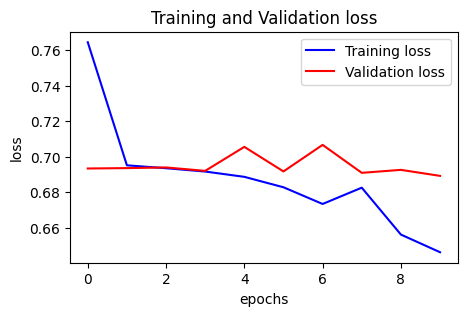

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = model.predict(X_test_cnn_nrm)
Y_pred_cnn = (pred_prob > 0.5).astype('int')

5/5 [==============================] - 0s 18ms/step


In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_cnn.reshape(-1), Y_pred_cnn.reshape(-1), rownames=['Actual label'], colnames=['Predicted label'])

Predicted label,0,1
Actual label,,
0,16,54
1,18,62


In [ ]:
# Creating a dictionary to store model performance metrics

cnn_mdl_2 = {}

cnn_mdl_2['Accuracy'] = round(accuracy_score(Y_test_cnn, Y_pred_cnn)*100)
cnn_mdl_2['Precision'] = round(precision_score(Y_test_cnn, Y_pred_cnn)*100)
cnn_mdl_2['Recall'] = round(recall_score(Y_test_cnn, Y_pred_cnn)*100)
cnn_mdl_2['F1_score'] = round(f1_score(Y_test_cnn, Y_pred_cnn)*100)

# Displaying the model performance metrics
cnn_mdl_2

{'Accuracy': 52, 'Precision': 53, 'Recall': 78, 'F1_score': 63}

## With Referenced Data (CAR)

### Preparing the training data

In [ ]:
print('Shape of referenced trials[1.0]:', trials_car[1.0].shape)
print('Shape of referenced trials[2.0]:', trials_car[2.0].shape)

Shape of referenced trials[1.0]: (2, 500, 149)
Shape of referenced trials[2.0]: (2, 500, 157)


CNN's are generally used for image tasks, and the norm is that input data has shape: samples x sequence_length x features.

If we take this analogy, then for our EEG data, we can consider the 2 channels as features and they should be at the end

In [ ]:
# Reshaping the data

x_1 = np.moveaxis(trials_car[1.0], 0,2)
x_1 = np.moveaxis(x_1, 0,1)

x_2 = np.moveaxis(trials_car[2.0], 0,2)
x_2 = np.moveaxis(x_2, 0,1)

x_1.shape, x_2.shape

((149, 500, 2), (157, 500, 2))

In [ ]:
X_train_cnn = np.vstack((x_1, x_2))
X_train_cnn.shape

(306, 500, 2)

In [ ]:
# Minimum and Maximum values

X_train_cnn.min(), X_train_cnn.max()

(-8.006892147917888, 8.006892147917888)

Data normalization is a best practice in deep learning, as it helps improve training stability, convergence speed, and the overall performance of CNN

In [ ]:
# Normalizing the data

min_value = np.min(X_train_cnn)
max_value = np.max(X_train_cnn)
X_train_cnn_nrm = (X_train_cnn - min_value) / (max_value - min_value)

X_train_cnn_nrm.min(), X_train_cnn_nrm.max()

(0.0, 1.0)

In [ ]:
# Getting train labels

Y_train_cnn.shape

(306, 1)

In [ ]:
np.unique(Y_train_cnn)

array([0, 1])

### Preparing the testing data

In [ ]:
# Applying the band-pass filter
test_trials_car = {'Test': avg_ref(test_trials['Test'])}
test_trials_car['Test'].shape

(2, 500, 150)

In [ ]:
_# Reshaping the data

X_test_cnn = np.moveaxis(test_trials_car['Test'], 0,2)
X_test_cnn = np.moveaxis(X_test_cnn, 0,1)
X_test_cnn.shape

(150, 500, 2)

In [ ]:
# Normalizing the data

X_test_cnn_nrm = (X_test_cnn - min_value) / (max_value - min_value)

X_test_cnn_nrm.min(), X_test_cnn_nrm.max()

(-1.3443272030134807, 2.344327203013481)

In [ ]:
# Getting test labels

Y_test_cnn.shape

(150, 1)

In [ ]:
np.unique(Y_test_cnn)

array([0, 1])

### Training the model

In [ ]:
# Getting the input shape

_, h, w = X_train_cnn.shape
h,w

(500, 2)

In [ ]:
# Setting the random seed for NumPy & Tensorflow to ensure result reproducibility

np.random.seed(1)
tf.random.set_seed(2)

In [ ]:
del model

In [ ]:
# Creating a CNN model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(h, w)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 498, 64)           448       
                                                                 
 conv1d_7 (Conv1D)           (None, 496, 64)           12352     
                                                                 
 dropout_3 (Dropout)         (None, 496, 64)           0         
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 248, 64)           0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 15872)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               1587300   
                                                      

In [ ]:
# hyper-parameters

epochs = 10
Optimizer = 'Adam'

In [ ]:
# Compiling the model

model.compile(optimizer=Optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
history = model.fit(X_train_cnn_nrm, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn_nrm, Y_test_cnn))

Epoch 1/10
10/10 [==============================] - 7s 216ms/step - loss: 0.7592 - accuracy: 0.4804 - val_loss: 0.6911 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 2/10
10/10 [==============================] - 1s 140ms/step - loss: 0.6942 - accuracy: 0.5131 - val_loss: 0.6928 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 3/10
10/10 [==============================] - 1s 133ms/step - loss: 0.6927 - accuracy: 0.5163 - val_loss: 0.6929 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 4/10
10/10 [==============================] - 1s 146ms/step - loss: 0.6919 - accuracy: 0.5621 - val_loss: 0.6920 - val_accuracy: 0.5400 - lr: 0.0010
Epoch 5/10
10/10 [==============================] - 1s 152ms/step - loss: 0.6912 - accuracy: 0.5392 - val_loss: 0.6942 - val_accuracy: 0.5133 - lr: 0.0010
Epoch 6/10
10/10 [==============================] - 2s 202ms/step - loss: 0.6842 - accuracy: 0.5784 - val_loss: 0.6934 - val_accuracy: 0.5267 - lr: 0.0010
Epoch 7/10
10/10 [==============================] - 2s 188ms/step - lo

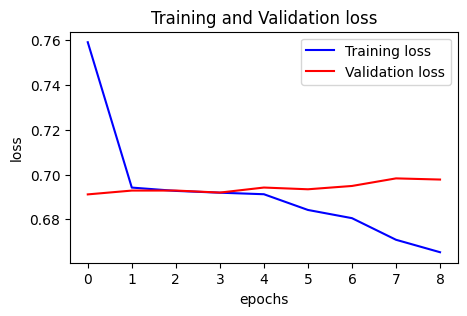

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = model.predict(X_test_cnn_nrm)
Y_pred_cnn = (pred_prob > 0.5).astype('int')

5/5 [==============================] - 0s 30ms/step


In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_cnn.reshape(-1), Y_pred_cnn.reshape(-1), rownames=['Actual label'], colnames=['Predicted label'])

Predicted label,0,1
Actual label,,
0,52,18
1,54,26


In [ ]:
# Creating a dictionary to store model performance metrics

cnn_mdl_car = {}

cnn_mdl_car['Accuracy'] = round(accuracy_score(Y_test_cnn, Y_pred_cnn)*100)
cnn_mdl_car['Precision'] = round(precision_score(Y_test_cnn, Y_pred_cnn)*100)
cnn_mdl_car['Recall'] = round(recall_score(Y_test_cnn, Y_pred_cnn)*100)
cnn_mdl_car['F1_score'] = round(f1_score(Y_test_cnn, Y_pred_cnn)*100)

# Displaying the model performance metrics
cnn_mdl_car

{'Accuracy': 52, 'Precision': 59, 'Recall': 32, 'F1_score': 42}

## With Transformed Data: Logarithm of Variance (log-var)

### Preparing the training data

In [ ]:
print('Shape of log_var trials[1.0]:', trials_logvar[1.0].shape)
print('Shape of log_var trials[2.0]:', trials_logvar[2.0].shape)

Shape of log_var trials[1.0]: (2, 149)
Shape of log_var trials[2.0]: (2, 157)


CNN's are generally used for image tasks, and the norm is that input data has shape: samples x sequence_length x features.

If we take this analogy, then for our EEG data, we can consider the 2 channels as features and they should be at the end

In [ ]:
# Reshaping the data

x_1 = np.moveaxis(trials_logvar[1.0], 0,1)

x_2 = np.moveaxis(trials_logvar[2.0], 0,1)

x_1.shape, x_2.shape

((149, 2), (157, 2))

In [ ]:
X_train_cnn = np.vstack((x_1, x_2))
X_train_cnn.shape

(306, 2)

In [ ]:
# First trial data

X_train_cnn[0]

array([1.65538533, 1.22774349])

But the data above dosent has the sequence_length dimension, so we will create a blank dimension to work with CNN

In [ ]:
X_train_cnn = np.expand_dims(X_train_cnn, axis=-1)
X_train_cnn.shape

(306, 2, 1)

In [ ]:
# First trial data

X_train_cnn[0]

array([[1.65538533],
       [1.22774349]])

In [ ]:
# We need to move the features dimension at the end

X_train_cnn = np.moveaxis(X_train_cnn, 1,2)
X_train_cnn.shape

(306, 1, 2)

In [ ]:
# First trial data

X_train_cnn[0]

array([[1.65538533, 1.22774349]])

In [ ]:
# Minimum and Maximum values

X_train_cnn.min(), X_train_cnn.max()

(-0.042490999112733505, 3.352244387965364)

Data normalization is a best practice in deep learning, as it helps improve training stability, convergence speed, and the overall performance of CNN

In [ ]:
# Normalizing the data

min_value = np.min(X_train_cnn)
max_value = np.max(X_train_cnn)
X_train_cnn_nrm = (X_train_cnn - min_value) / (max_value - min_value)

X_train_cnn_nrm.min(), X_train_cnn_nrm.max()

(0.0, 1.0)

In [ ]:
# Getting train labels

Y_train_cnn.shape

(306, 1)

In [ ]:
np.unique(Y_train_cnn)

array([0, 1])

### Preparing the testing data

In [ ]:
# Band-pass filtered Data
test_trials_filt['Test'].shape

(2, 500, 150)

In [ ]:
# Performing the log-var transformation
test_trials_logvar = {'Test': logvar(test_trials_filt['Test'])}
test_trials_logvar['Test'].shape

(2, 150)

In [ ]:
# Reshaping the data

X_test_cnn = np.moveaxis(test_trials_logvar['Test'], 0,1)
X_test_cnn.shape

(150, 2)

In [ ]:
# Adding a blank dimension for sequence_length

X_test_cnn = np.expand_dims(X_test_cnn, axis=-1)
X_test_cnn = np.moveaxis(X_test_cnn, 1,2)
X_test_cnn.shape

(150, 1, 2)

In [ ]:
# Normalizing the data

X_test_cnn_nrm = (X_test_cnn - min_value) / (max_value - min_value)

X_test_cnn_nrm.min(), X_test_cnn_nrm.max()

(-0.10642297425232002, 0.8907845642330797)

In [ ]:
# Getting test labels

Y_test_cnn.shape

(150, 1)

In [ ]:
np.unique(Y_test_cnn)

array([0, 1])

### Training the model

In [ ]:
# Getting the input shape

_, h, w = X_train_cnn.shape
h,w

(1, 2)

In [ ]:
# Setting the random seed for NumPy & Tensorflow to ensure result reproducibility

np.random.seed(1)
tf.random.set_seed(2)

In [ ]:
# Creating a CNN model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(h, w)))
model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_21 (Conv1D)          (None, 1, 64)             192       
                                                                 
 conv1d_22 (Conv1D)          (None, 1, 64)             4160      
                                                                 
 dropout_8 (Dropout)         (None, 1, 64)             0         
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 1, 64)             0         
 ng1D)                                                           
                                                                 
 flatten_8 (Flatten)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 100)               6500      
                                                     

In [ ]:
# hyper-parameters

epochs = 10
Optimizer = 'Adam'

In [ ]:
# Compiling the model

model.compile(optimizer=Optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
history = model.fit(X_train_cnn, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn, Y_test_cnn))

Epoch 1/10
10/10 [==============================] - 1s 28ms/step - loss: 0.7012 - accuracy: 0.4804 - val_loss: 0.6901 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 2/10
10/10 [==============================] - 0s 9ms/step - loss: 0.6961 - accuracy: 0.4935 - val_loss: 0.6878 - val_accuracy: 0.5600 - lr: 0.0010
Epoch 3/10
10/10 [==============================] - 0s 7ms/step - loss: 0.6877 - accuracy: 0.5425 - val_loss: 0.6864 - val_accuracy: 0.5533 - lr: 0.0010
Epoch 4/10
10/10 [==============================] - 0s 8ms/step - loss: 0.6936 - accuracy: 0.5000 - val_loss: 0.6852 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 5/10
10/10 [==============================] - 0s 9ms/step - loss: 0.6977 - accuracy: 0.5261 - val_loss: 0.6841 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 6/10
10/10 [==============================] - 0s 7ms/step - loss: 0.6893 - accuracy: 0.5000 - val_loss: 0.6831 - val_accuracy: 0.6200 - lr: 0.0010
Epoch 7/10
10/10 [==============================] - 0s 7ms/step - loss: 0.6863 - 

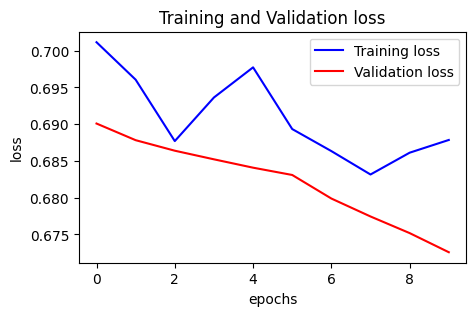

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = model.predict(X_test_cnn)
Y_pred_cnn = (pred_prob > 0.5).astype('int')

5/5 [==============================] - 0s 4ms/step


In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_cnn.reshape(-1), Y_pred_cnn.reshape(-1), rownames=['Actual label'], colnames=['Predicted label'])

Predicted label,0,1
Actual label,,
0,35,35
1,23,57


In [ ]:
# Creating a dictionary to store model performance metrics

cnn_mdl_3 = {}

cnn_mdl_3['Accuracy'] = round(accuracy_score(Y_test_cnn, Y_pred_cnn)*100)
cnn_mdl_3['Precision'] = round(precision_score(Y_test_cnn, Y_pred_cnn)*100)
cnn_mdl_3['Recall'] = round(recall_score(Y_test_cnn, Y_pred_cnn)*100)
cnn_mdl_3['F1_score'] = round(f1_score(Y_test_cnn, Y_pred_cnn)*100)

# Displaying the model performance metrics
cnn_mdl_3

{'Accuracy': 61, 'Precision': 62, 'Recall': 71, 'F1_score': 66}

## With Transformed Data: Short-term Fourier transform (STFT)

### Preparing the training data

In [ ]:
print('Shape of filtered trials[1.0]:', trials_filt[1.0].shape)
print('Shape of filtered trials[2.0]:', trials_filt[2.0].shape)

Shape of filtered trials[1.0]: (2, 500, 149)
Shape of filtered trials[2.0]: (2, 500, 157)


In [ ]:
# Reshaping the data

x_1 = np.moveaxis(trials_filt[1.0], 0,2)
x_1 = np.moveaxis(x_1, 0,1)

x_2 = np.moveaxis(trials_filt[2.0], 0,2)
x_2 = np.moveaxis(x_2, 0,1)

x_1.shape, x_2.shape

((149, 500, 2), (157, 500, 2))

In [ ]:
# Creating the training data
data_array = np.vstack((x_1, x_2))
data_array.shape

(306, 500, 2)

Performing STFT

In [ ]:
# STFT parameters
fs = sample_rate # Sampling frequency
nperseg = nsamples  # Length of each segment
noverlap = 32  # Overlap between segments

fs, nperseg, noverlap

(125, 500, 32)

In [ ]:
# Perform STFT for each channel
stft_results = []
for channel in range(data_array.shape[2]):  # Iterate over channels
    channel_data = data_array[:, :, channel]  # Extract data for each channel
    _, _, stft_data = stft(channel_data, fs=fs, nperseg=nperseg, noverlap=noverlap)
    stft_results.append(stft_data)

# Convert the results to a NumPy array
stft_results = np.array(stft_results)
stft_results.shape

# The shape of 'stft_results' will be (channels, trials, frequency_bins, time_bins)

(2, 306, 251, 3)

In [ ]:
# Reshaping the data

X_train_cnn = np.moveaxis(stft_results, 0,-1)
X_train_cnn.shape

# Now the data is in shape: trials * frequency_bins * time_bins * channels

(306, 251, 3, 2)

In [ ]:
# The two channels (C3 and C4) are stacked one below another to form a single image

X_train_cnn = X_train_cnn.reshape(306, -1, 3)
X_train_cnn.shape

(306, 502, 3)

In [ ]:
X_train_cnn.sum()

(-0.07398463151301729-0.042069224690892214j)

In [ ]:
# Converting the complex number into real by taking the magnitude

X_train_cnn = np.abs(X_train_cnn)

Data normalization is a best practice in deep learning, as it helps improve training stability, convergence speed, and the overall performance of CNN

In [ ]:
# Normalizing the data

min_value = np.min(X_train_cnn)
max_value = np.max(X_train_cnn)
X_train_cnn_nrm = (X_train_cnn - min_value) / (max_value - min_value)

X_train_cnn_nrm.min(), X_train_cnn_nrm.max()

(0.0, 1.0)

In [ ]:
# Getting train labels

Y_train_cnn.shape

(306, 1)

In [ ]:
np.unique(Y_train_cnn)

array([0, 1])

### Preparing the testing data

In [ ]:
# Original testing trials data

test_trials['Test'].shape

(2, 500, 150)

In [ ]:
# Reshaping the data

data_array = np.moveaxis(test_trials['Test'], 0,2)
data_array = np.moveaxis(data_array, 0,1)
data_array.shape

(150, 500, 2)

In [ ]:
# Perform STFT for each channel
stft_results = []
for channel in range(data_array.shape[2]):  # Iterate over channels
    channel_data = data_array[:, :, channel]  # Extract data for each channel
    _, _, stft_data = stft(channel_data, fs=fs, nperseg=nperseg, noverlap=noverlap)
    stft_results.append(stft_data)

# Convert the results to a NumPy array
stft_results = np.array(stft_results)
stft_results.shape

# The shape of 'stft_results' will be (channels, trials, frequency_bins, time_bins)

(2, 150, 251, 3)

In [ ]:
# Reshaping the data

X_test_cnn = np.moveaxis(stft_results, 0,-1)
X_test_cnn.shape

# Now the data is in shape: trials * frequency_bins * time_bins * channels

(150, 251, 3, 2)

In [ ]:
# The two channels (C3 and C4) are stacked one below another to form a single image

X_test_cnn = X_test_cnn.reshape(150, -1, 3)
X_test_cnn.shape

(150, 502, 3)

In [ ]:
X_test_cnn.sum()

(13.216857580825115+5.863533888125767j)

In [ ]:
# Converting the complex number into real by taking the magnitude

X_test_cnn = np.abs(X_test_cnn)

In [ ]:
# Normalizing the data

X_test_cnn_nrm = (X_test_cnn - min_value) / (max_value - min_value)

X_test_cnn_nrm.min(), X_test_cnn_nrm.max()

(0.0, 1.6314435859800842)

In [ ]:
# Getting test labels

Y_test_cnn.shape

(150, 1)

In [ ]:
np.unique(Y_test_cnn)

array([0, 1])

### Training the model

In [ ]:
# Getting the input shape

_, h, w = X_train_cnn.shape
h,w

(502, 3)

In [ ]:
# Creating a CNN model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(h, w)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_80 (Conv1D)          (None, 500, 64)           640       
                                                                 
 conv1d_81 (Conv1D)          (None, 498, 64)           12352     
                                                                 
 dropout_15 (Dropout)        (None, 498, 64)           0         
                                                                 
 max_pooling1d_17 (MaxPooli  (None, 249, 64)           0         
 ng1D)                                                           
                                                                 
 flatten_15 (Flatten)        (None, 15936)             0         
                                                                 
 dense_34 (Dense)            (None, 100)               1593700   
                                                     

In [ ]:
# hyper-parameters

epochs = 10
Optimizer = 'Adam'

In [ ]:
# Compiling the model

model.compile(optimizer=Optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
history = model.fit(np.abs(X_train_cnn_nrm), Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(np.abs(X_test_cnn_nrm), Y_test_cnn))

Epoch 1/10
10/10 [==============================] - 3s 169ms/step - loss: 0.6975 - accuracy: 0.4967 - val_loss: 0.6906 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 2/10
10/10 [==============================] - 1s 125ms/step - loss: 0.6918 - accuracy: 0.5458 - val_loss: 0.6907 - val_accuracy: 0.5533 - lr: 0.0010
Epoch 3/10
10/10 [==============================] - 1s 80ms/step - loss: 0.6879 - accuracy: 0.5131 - val_loss: 0.6859 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 4/10
10/10 [==============================] - 1s 90ms/step - loss: 0.6775 - accuracy: 0.6176 - val_loss: 0.6759 - val_accuracy: 0.5867 - lr: 0.0010
Epoch 5/10
10/10 [==============================] - 1s 81ms/step - loss: 0.6562 - accuracy: 0.6209 - val_loss: 0.6870 - val_accuracy: 0.5200 - lr: 0.0010
Epoch 6/10
10/10 [==============================] - 1s 81ms/step - loss: 0.6261 - accuracy: 0.6569 - val_loss: 0.6669 - val_accuracy: 0.5467 - lr: 0.0010
Epoch 7/10
10/10 [==============================] - 1s 90ms/step - loss: 0

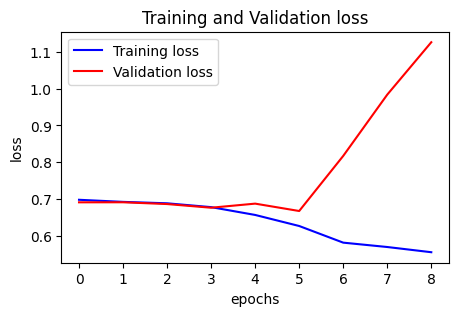

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = model.predict(np.abs(X_test_cnn_nrm))
Y_pred_cnn = (pred_prob > 0.5).astype('int')

5/5 [==============================] - 0s 28ms/step


In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_cnn.reshape(-1), Y_pred_cnn.reshape(-1), rownames=['Actual label'], colnames=['Predicted label'])

Predicted label,0,1
Actual label,,
0,1,69
1,0,80


In [ ]:
# Creating a dictionary to store model performance metrics

cnn_mdl_4 = {}

cnn_mdl_4['Accuracy'] = round(accuracy_score(Y_test_cnn, Y_pred_cnn)*100)
cnn_mdl_4['Precision'] = round(precision_score(Y_test_cnn, Y_pred_cnn)*100)
cnn_mdl_4['Recall'] = round(recall_score(Y_test_cnn, Y_pred_cnn)*100)
cnn_mdl_4['F1_score'] = round(f1_score(Y_test_cnn, Y_pred_cnn)*100)

# Displaying the model performance metrics
cnn_mdl_4

{'Accuracy': 54, 'Precision': 54, 'Recall': 100, 'F1_score': 70}

#### Optimal probability cut-off

In [ ]:
# Make predictions on the test set

y_pred_probabilities = model.predict(X_test_cnn_nrm)

5/5 [==============================] - 0s 23ms/step


In [ ]:
# Calculating sensitivity and specificity for different probability cut-offs

cut_off_prob = np.linspace(0,1,50)

sensitivity, specificity, TPR, FPR = opt_prob(cut_off_prob, Y_test_cnn.reshape(-1), y_pred_probabilities)

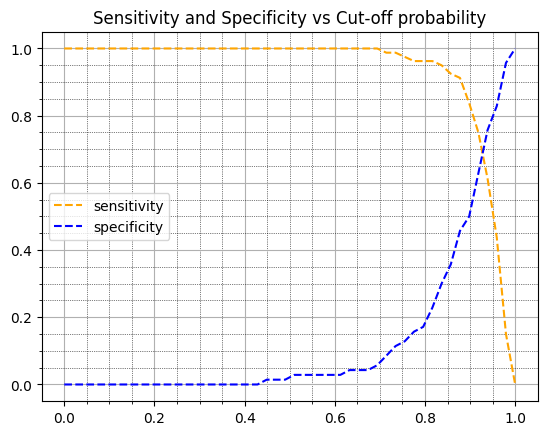

In [ ]:
# Plotting sensitivity and specificity to identify the optimal cut-off

sns.lineplot(x=cut_off_prob, y=sensitivity, color='orange', linestyle='--', label='sensitivity').minorticks_on()
sns.lineplot(x=cut_off_prob, y=specificity, color='blue', linestyle='--', label='specificity').grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title("Sensitivity and Specificity vs Cut-off probability")
plt.grid()
plt.show()

Optimal probability cutoff is ~0.9

In [ ]:
prob_cut_off = 0.9

# Convert probabilities to class labels
Y_pred_cnn = (y_pred_probabilities > prob_cut_off).astype(int)


np.unique(Y_pred_cnn)

array([0, 1])

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_cnn.reshape(-1), Y_pred_cnn.reshape(-1), rownames=['Actual label'], colnames=['Predicted label'])

Predicted label,0,1
Actual label,,
0,35,35
1,13,67


In [ ]:
# Creating a dictionary to store model performance metrics

cnn_mdl_4 = {}

cnn_mdl_4['Accuracy'] = round(accuracy_score(Y_test_cnn, Y_pred_cnn)*100)
cnn_mdl_4['Precision'] = round(precision_score(Y_test_cnn, Y_pred_cnn)*100)
cnn_mdl_4['Recall'] = round(recall_score(Y_test_cnn, Y_pred_cnn)*100)
cnn_mdl_4['F1_score'] = round(f1_score(Y_test_cnn, Y_pred_cnn)*100)

# Displaying the model performance metrics
cnn_mdl_4

{'Accuracy': 68, 'Precision': 66, 'Recall': 84, 'F1_score': 74}

**CNN Models comparison**

In [ ]:
print("CNN with raw data:", cnn_mdl_1)
print("CNN with flitered data:", cnn_mdl_2)
print("CNN with log-var transformed data:", cnn_mdl_3)
print("CNN with STFT transformed data:", cnn_mdl_4)

CNN with raw data: {'Accuracy': 47, 'Precision': 0, 'Recall': 0, 'F1_score': 0}
CNN with flitered data: {'Accuracy': 52, 'Precision': 53, 'Recall': 78, 'F1_score': 63}
CNN with log-var transformed data: {'Accuracy': 61, 'Precision': 62, 'Recall': 71, 'F1_score': 66}
CNN with STFT transformed data: {'Accuracy': 68, 'Precision': 66, 'Recall': 84, 'F1_score': 74}


# ChronoNet (CNN-RNN) Classifier

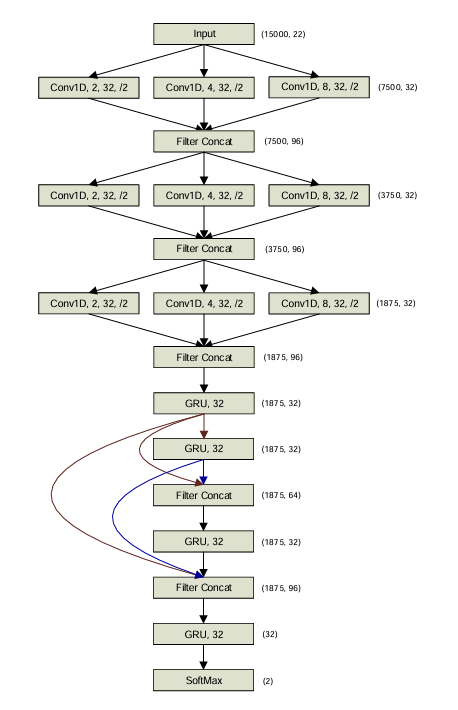

## With Raw Data

### Preparing the training data

In [ ]:
# Original training trials data

print('Shape of trials[1.0]:', trials[1.0].shape)
print('Shape of trials[2.0]:', trials[2.0].shape)

Shape of trials[1.0]: (2, 500, 149)
Shape of trials[2.0]: (2, 500, 157)


CNN's are generally used for image tasks, and the norm is that input data has shape: samples x sequence_length x features.

If we take this analogy, then for our EEG data, we can consider the 2 channels as features and they should be at the end

In [ ]:
# Reshaping the data

x_1 = np.moveaxis(trials[1.0], 0,2)
x_1 = np.moveaxis(x_1, 0,1)

x_2 = np.moveaxis(trials[2.0], 0,2)
x_2 = np.moveaxis(x_2, 0,1)

x_1.shape, x_2.shape

((149, 500, 2), (157, 500, 2))

In [ ]:
X_train_cnn = np.vstack((x_1, x_2))
X_train_cnn.shape

(306, 500, 2)

In [ ]:
# Minimum and Maximum values

X_train_cnn.min(), X_train_cnn.max()

(-35.289093, 40.392062)

Data normalization is a best practice in deep learning, as it helps improve training stability, convergence speed, and the overall performance of CNN

In [ ]:
# Normalizing the data

min_value = np.min(X_train_cnn)
max_value = np.max(X_train_cnn)
X_train_cnn_nrm = (X_train_cnn - min_value) / (max_value - min_value)

X_train_cnn_nrm.min(), X_train_cnn_nrm.max()

(0.0, 1.0)

In [ ]:
# Getting train labels

Y_train_cnn = Y_train_rf.reshape(Y_train_rf.shape[0], 1)
Y_train_cnn.shape

(306, 1)

In [ ]:
np.unique(Y_train_cnn)

array([1, 2])

As its a binary classifier, we will change the labels to 0 & 1

In [ ]:
# Re-mapping class labels

Y_train_cnn = Y_train_cnn - 1
np.unique(Y_train_cnn)

array([0, 1])

### Preparing the testing data

In [ ]:
# Original testing trials data

test_trials['Test'].shape

(2, 500, 150)

In [ ]:
# Reshaping the data

X_test_cnn = np.moveaxis(test_trials['Test'], 0,2)
X_test_cnn = np.moveaxis(X_test_cnn, 0,1)
X_test_cnn.shape

(150, 500, 2)

In [ ]:
# Normalizing the data

X_test_cnn_nrm = (X_test_cnn - min_value) / (max_value - min_value)

X_test_cnn_nrm.min(), X_test_cnn_nrm.max()

(-0.02227418437258256, 0.9885504654362105)

In [ ]:
# Getting test labels

Y_test_cnn = Y_test_rf.reshape(Y_test_rf.shape[0], 1)
Y_test_cnn.shape

(150, 1)

In [ ]:
np.unique(Y_test_cnn)

array([1, 2])

In [ ]:
# Re-mapping class labels

Y_test_cnn = Y_test_cnn - 1
np.unique(Y_test_cnn)

array([0, 1])

### Training the model

In [ ]:
# Getting the input shape

_, h, w = X_train_cnn.shape
h,w

(500, 2)

In [ ]:
# Setting the random seed for NumPy & Tensorflow to ensure result reproducibility

np.random.seed(1)
tf.random.set_seed(2)

In [ ]:
# Creating the ChronoNet model

def block(input):
  conv1 = Conv1D(32, 2, strides=2,activation='relu',padding="same")(input)
  conv2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(input)
  conv3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(input)
  x = concatenate([conv1,conv2,conv3],axis=2)
  return x


ip_layer= Input(shape=(h, w))
block1=block(ip_layer)
block2=block(block1)
block3=block(block2)


gru_out1 = GRU(32,activation='tanh',return_sequences=True)(block3)
gru_out2 = GRU(32,activation='tanh',return_sequences=True)(gru_out1)
gru_out = concatenate([gru_out1,gru_out2],axis=2)
gru_out3 = GRU(32,activation='tanh',return_sequences=True)(gru_out)
gru_out = concatenate([gru_out1,gru_out2,gru_out3])
gru_out4 = GRU(32,activation='tanh')(gru_out)


op_layer = Dense(1, activation='sigmoid')(gru_out4)
chrono_model = Model(inputs=ip_layer, outputs=op_layer)

chrono_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 500, 2)]             0         []                            
                                                                                                  
 conv1d_44 (Conv1D)          (None, 250, 32)              160       ['input_2[0][0]']             
                                                                                                  
 conv1d_45 (Conv1D)          (None, 250, 32)              288       ['input_2[0][0]']             
                                                                                                  
 conv1d_46 (Conv1D)          (None, 250, 32)              544       ['input_2[0][0]']             
                                                                                            

In [ ]:
# hyper-parameters

epochs = 10
Optimizer = 'Adam'

In [ ]:
# Compiling the model

chrono_model.compile(optimizer=Optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
history = chrono_model.fit(X_train_cnn, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn, Y_test_cnn))

Epoch 1/10
10/10 [==============================] - 15s 481ms/step - loss: 0.7408 - accuracy: 0.5033 - val_loss: 0.7335 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 2/10
10/10 [==============================] - 3s 317ms/step - loss: 0.7220 - accuracy: 0.5392 - val_loss: 0.6998 - val_accuracy: 0.5267 - lr: 0.0010
Epoch 3/10
10/10 [==============================] - 2s 231ms/step - loss: 0.6835 - accuracy: 0.5229 - val_loss: 0.7023 - val_accuracy: 0.4867 - lr: 0.0010
Epoch 4/10
10/10 [==============================] - 2s 219ms/step - loss: 0.6582 - accuracy: 0.6078 - val_loss: 0.7179 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 5/10
10/10 [==============================] - 2s 216ms/step - loss: 0.6143 - accuracy: 0.7190 - val_loss: 0.7587 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/10
10/10 [==============================] - 2s 208ms/step - loss: 0.5546 - accuracy: 0.7614 - val_loss: 0.7540 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 7/10
10/10 [==============================] - 2s 256ms/step - l

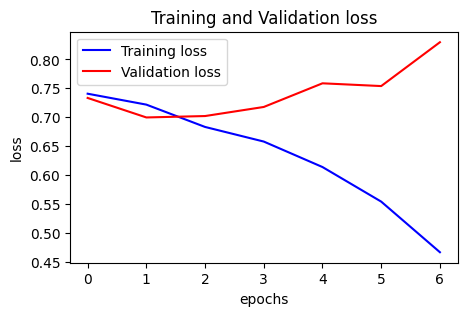

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = chrono_model.predict(X_test_cnn)
Y_pred_cnn = (pred_prob > 0.5).astype('int')

5/5 [==============================] - 2s 37ms/step


In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_cnn.reshape(-1), Y_pred_cnn.reshape(-1), rownames=['Actual label'], colnames=['Predicted label'])

Predicted label,0,1
Actual label,,
0,16,54
1,25,55


In [ ]:
# Creating a dictionary to store model performance metrics

chrono_mdl_1 = {}

chrono_mdl_1['Accuracy'] = round(accuracy_score(Y_test_cnn, Y_pred_cnn)*100)
chrono_mdl_1['Precision'] = round(precision_score(Y_test_cnn, Y_pred_cnn)*100)
chrono_mdl_1['Recall'] = round(recall_score(Y_test_cnn, Y_pred_cnn)*100)
chrono_mdl_1['F1_score'] = round(f1_score(Y_test_cnn, Y_pred_cnn)*100)

# Displaying the model performance metrics
chrono_mdl_1

{'Accuracy': 47, 'Precision': 50, 'Recall': 69, 'F1_score': 58}

#### Optimal probability cut-off

In [ ]:
# Creating a function to calculate various model performance metrics (sensivity, specificity etc.) for a given probablity cut-off

def perf_metrics(cut_off, Y_test, pred_prob):

  # Getting the class labels
  false_class , true_class = np.sort(np.unique(Y_test))

  # Creating a dataframe with actual and predcited Y
  df = pd.DataFrame()
  df['Y_actual'] = Y_test
  df['pred_prob'] = pred_prob
  df['Y_pred'] = list(map(lambda x: true_class if x > cut_off else false_class, df.pred_prob))

  # Calculating TP, TN, FP & FN
  df['TP'] = list(map(lambda x,y: 1 if x==y==true_class else 0, df.Y_actual, df.Y_pred))
  df['TN'] = list(map(lambda x,y: 1 if x==y==false_class else 0, df.Y_actual, df.Y_pred))
  df['FP'] = list(map(lambda x,y: 1 if ((x==false_class) & (y==true_class)) else 0, df.Y_actual, df.Y_pred))
  df['FN'] = list(map(lambda x,y: 1 if ((x==true_class) & (y==false_class)) else 0, df.Y_actual, df.Y_pred))

  TP = sum(df.TP)
  TN = sum(df.TN)
  FP = sum(df.FP)
  FN = sum(df.FN)

  # Calculating model performance metrics
  try:
    sensitivity = TP/(TP+FN)
  except:
    sensitivity = 0

  TPR = recall = sensitivity

  try:
    specificity = TN/(TN+FP)
  except:
    specificity = 0

  try:
    precision = TP/(TP+FP)
  except:
    precision = 0

  try:
    F_measure = (2*precision*recall)/(precision+recall)
  except:
    F_measure = 0

  try:
    FPR = 1 - specificity
  except:
    FPR = 0

  return sensitivity, specificity, precision, F_measure, TPR, FPR


In [ ]:
def opt_prob(cut_off_prob, Y_test, pred_prob):
  sensitivity=[]
  specificity=[]
  precision=[]
  F_measure=[]
  TPR=[]
  FPR=[]

  # Iterating over different cut-off probabilities and calculating the performance metrics
  for p in cut_off_prob:
    sen, spe, pre, fsc, tpr, fpr = perf_metrics(p, Y_test, pred_prob)
    sensitivity.append(sen)
    specificity.append(spe)
    precision.append(pre)
    F_measure.append(fsc)
    TPR.append(tpr)
    FPR.append(fpr)

  return sensitivity, specificity, TPR, FPR

In [ ]:
# Make predictions on the test set

y_pred_probabilities = chrono_model.predict(X_test_cnn)

5/5 [==============================] - 0s 37ms/step


In [ ]:
# Calculating sensitivity and specificity for different probability cut-offs

cut_off_prob = np.linspace(0,1,50)

sensitivity, specificity, TPR, FPR = opt_prob(cut_off_prob, Y_test_cnn.reshape(-1), y_pred_probabilities)

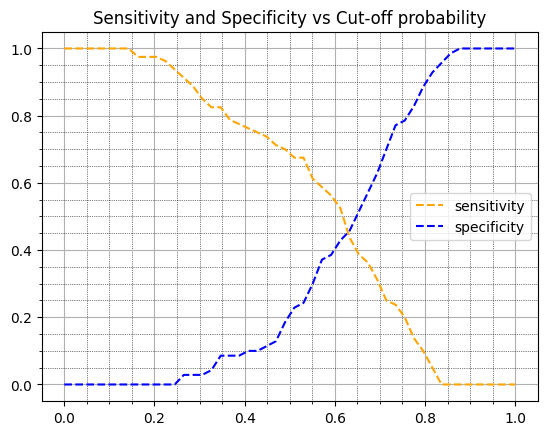

In [ ]:
# Plotting sensitivity and specificity to identify the optimal cut-off

sns.lineplot(x=cut_off_prob, y=sensitivity, color='orange', linestyle='--', label='sensitivity').minorticks_on()
sns.lineplot(x=cut_off_prob, y=specificity, color='blue', linestyle='--', label='specificity').grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title("Sensitivity and Specificity vs Cut-off probability")
plt.grid()
plt.show()

Optimal probability cutoff is ~0.52

In [ ]:
prob_cut_off = 0.52

# Convert probabilities to class labels
Y_pred_cnn = (y_pred_probabilities > prob_cut_off).astype(int)


np.unique(Y_pred_cnn)

array([0, 1])

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_cnn.reshape(-1), Y_pred_cnn.reshape(-1), rownames=['Actual label'], colnames=['Predicted label'])

Predicted label,0,1
Actual label,,
0,16,54
1,26,54


In [ ]:
# Calculating the performance metrics

print("Accuracy:", round(accuracy_score(Y_test_cnn, Y_pred_cnn)*100),"%")

print("\nPrecision:", round(precision_score(Y_test_cnn, Y_pred_cnn)*100),"%")

print("\nRecall:", round(recall_score(Y_test_cnn, Y_pred_cnn)*100),"%")

print("\nF1_score:", round(f1_score(Y_test_cnn, Y_pred_cnn)*100),"%")

Accuracy: 47 %

Precision: 50 %

Recall: 68 %

F1_score: 57 %


In [ ]:
chrono_mdl_1

{'Accuracy': 47, 'Precision': 50, 'Recall': 69, 'F1_score': 58}

## With Filtered Data (band-pass)

### Preparing the training data

In [ ]:
print('Shape of filtered trials[1.0]:', trials_filt[1.0].shape)
print('Shape of filtered trials[2.0]:', trials_filt[2.0].shape)

Shape of filtered trials[1.0]: (2, 500, 149)
Shape of filtered trials[2.0]: (2, 500, 157)


CNN's are generally used for image tasks, and the norm is that input data has shape: samples x sequence_length x features.

If we take this analogy, then for our EEG data, we can consider the 2 channels as features and they should be at the end

In [ ]:
# Reshaping the data

x_1 = np.moveaxis(trials_filt[1.0], 0,2)
x_1 = np.moveaxis(x_1, 0,1)

x_2 = np.moveaxis(trials_filt[2.0], 0,2)
x_2 = np.moveaxis(x_2, 0,1)

x_1.shape, x_2.shape

((149, 500, 2), (157, 500, 2))

In [ ]:
X_train_cnn = np.vstack((x_1, x_2))
X_train_cnn.shape

(306, 500, 2)

In [ ]:
# Minimum and Maximum values

X_train_cnn.min(), X_train_cnn.max()

(-18.40416822978628, 17.588101355206373)

Data normalization is a best practice in deep learning, as it helps improve training stability, convergence speed, and the overall performance of CNN

In [ ]:
# Normalizing the data

min_value = np.min(X_train_cnn)
max_value = np.max(X_train_cnn)
X_train_cnn_nrm = (X_train_cnn - min_value) / (max_value - min_value)

X_train_cnn_nrm.min(), X_train_cnn_nrm.max()

(0.0, 1.0)

In [ ]:
# Getting train labels

Y_train_cnn.shape

(306, 1)

In [ ]:
np.unique(Y_train_cnn)

array([0, 1])

### Preparing the testing data

In [ ]:
# Raw Test Data
test_trials['Test'].shape

# Applying the band-pass filter
test_trials_filt = {'Test': bandpass(test_trials['Test'], 8, 15, sample_rate)}
test_trials_filt['Test'].shape

(2, 500, 150)

In [ ]:
# Reshaping the data

X_test_cnn = np.moveaxis(test_trials_filt['Test'], 0,2)
X_test_cnn = np.moveaxis(X_test_cnn, 0,1)
X_test_cnn.shape

(150, 500, 2)

In [ ]:
# Normalizing the data

X_test_cnn_nrm = (X_test_cnn - min_value) / (max_value - min_value)

X_test_cnn_nrm.min(), X_test_cnn_nrm.max()

(-0.03893295108946009, 1.0624754221575632)

In [ ]:
# Getting test labels

Y_test_cnn.shape

(150, 1)

In [ ]:
np.unique(Y_test_cnn)

array([0, 1])

### Training the model

In [ ]:
# Deleting the previous instance of ChronoNet model
try:
  del chrono_model
except:
  pass

In [ ]:
# Instantiating the ChronoNet model

chrono_model = Model(inputs=ip_layer, outputs=op_layer)
chrono_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 500, 2)]             0         []                            
                                                                                                  
 conv1d_44 (Conv1D)          (None, 250, 32)              160       ['input_2[0][0]']             
                                                                                                  
 conv1d_45 (Conv1D)          (None, 250, 32)              288       ['input_2[0][0]']             
                                                                                                  
 conv1d_46 (Conv1D)          (None, 250, 32)              544       ['input_2[0][0]']             
                                                                                            

In [ ]:
# hyper-parameters

epochs = 10
Optimizer = 'Adam'

In [ ]:
# Compiling the model

chrono_model.compile(optimizer=Optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
history = chrono_model.fit(X_train_cnn_nrm, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn_nrm, Y_test_cnn))

Epoch 1/10
10/10 [==============================] - 15s 525ms/step - loss: 0.7041 - accuracy: 0.4771 - val_loss: 0.6907 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 2/10
10/10 [==============================] - 2s 232ms/step - loss: 0.6939 - accuracy: 0.4837 - val_loss: 0.6934 - val_accuracy: 0.4933 - lr: 0.0010
Epoch 3/10
10/10 [==============================] - 2s 216ms/step - loss: 0.6935 - accuracy: 0.5033 - val_loss: 0.6910 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 4/10
10/10 [==============================] - 2s 206ms/step - loss: 0.6909 - accuracy: 0.5196 - val_loss: 0.6924 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 5/10
10/10 [==============================] - 2s 200ms/step - loss: 0.6914 - accuracy: 0.5163 - val_loss: 0.6918 - val_accuracy: 0.5200 - lr: 0.0010
Epoch 6/10
10/10 [==============================] - 2s 199ms/step - loss: 0.6900 - accuracy: 0.5000 - val_loss: 0.6925 - val_accuracy: 0.5000 - lr: 0.0010


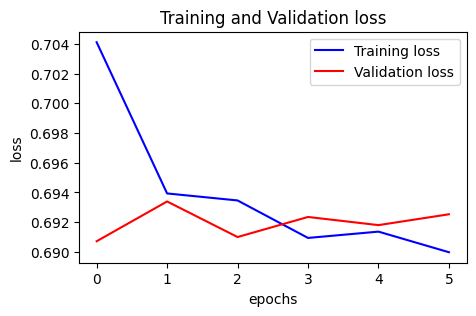

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = chrono_model.predict(X_test_cnn_nrm)
Y_pred_cnn = (pred_prob > 0.5).astype('int')

5/5 [==============================] - 2s 38ms/step


In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_cnn.reshape(-1), Y_pred_cnn.reshape(-1), rownames=['Actual label'], colnames=['Predicted label'])

Predicted label,0,1
Actual label,,
0,48,22
1,53,27


In [ ]:
# Creating a dictionary to store model performance metrics

chrono_mdl_2 = {}

chrono_mdl_2['Accuracy'] = round(accuracy_score(Y_test_cnn, Y_pred_cnn)*100)
chrono_mdl_2['Precision'] = round(precision_score(Y_test_cnn, Y_pred_cnn)*100)
chrono_mdl_2['Recall'] = round(recall_score(Y_test_cnn, Y_pred_cnn)*100)
chrono_mdl_2['F1_score'] = round(f1_score(Y_test_cnn, Y_pred_cnn)*100)

# Displaying the model performance metrics
chrono_mdl_2

{'Accuracy': 50, 'Precision': 55, 'Recall': 34, 'F1_score': 42}

## With Transformed Data: Logarithm of Variance (log-var)

### Preparing the training data

In [ ]:
print('Shape of log_var trials[1.0]:', trials_logvar[1.0].shape)
print('Shape of log_var trials[2.0]:', trials_logvar[2.0].shape)

Shape of log_var trials[1.0]: (2, 149)
Shape of log_var trials[2.0]: (2, 157)


CNN's are generally used for image tasks, and the norm is that input data has shape: samples x sequence_length x features.

If we take this analogy, then for our EEG data, we can consider the 2 channels as features and they should be at the end

In [ ]:
# Reshaping the data

x_1 = np.moveaxis(trials_logvar[1.0], 0,1)

x_2 = np.moveaxis(trials_logvar[2.0], 0,1)

x_1.shape, x_2.shape

((149, 2), (157, 2))

In [ ]:
X_train_cnn = np.vstack((x_1, x_2))
X_train_cnn.shape

(306, 2)

In [ ]:
# First trial data

X_train_cnn[0]

array([1.65538533, 1.22774349])

But the data above dosent has the sequence_length dimension, so we will create a blank dimension to work with CNN

In [ ]:
X_train_cnn = np.expand_dims(X_train_cnn, axis=-1)
X_train_cnn.shape

(306, 2, 1)

In [ ]:
# First trial data

X_train_cnn[0]

array([[1.65538533],
       [1.22774349]])

In [ ]:
# We need to move the features dimension at the end

X_train_cnn = np.moveaxis(X_train_cnn, 1,2)
X_train_cnn.shape

(306, 1, 2)

In [ ]:
# First trial data

X_train_cnn[0]

array([[1.65538533, 1.22774349]])

In [ ]:
# Minimum and Maximum values

X_train_cnn.min(), X_train_cnn.max()

(-0.042490999112733505, 3.352244387965364)

Data normalization is a best practice in deep learning, as it helps improve training stability, convergence speed, and the overall performance of CNN

In [ ]:
# Normalizing the data

min_value = np.min(X_train_cnn)
max_value = np.max(X_train_cnn)
X_train_cnn_nrm = (X_train_cnn - min_value) / (max_value - min_value)

X_train_cnn_nrm.min(), X_train_cnn_nrm.max()

(0.0, 1.0)

In [ ]:
# Getting train labels

Y_train_cnn.shape

(306, 1)

In [ ]:
np.unique(Y_train_cnn)

array([0, 1])

### Preparing the testing data

In [ ]:
# Band-pass filtered Data
test_trials_filt['Test'].shape

(2, 500, 150)

In [ ]:
# Performing the log-var transformation
test_trials_logvar = {'Test': logvar(test_trials_filt['Test'])}
test_trials_logvar['Test'].shape

(2, 150)

In [ ]:
# Reshaping the data

X_test_cnn = np.moveaxis(test_trials_logvar['Test'], 0,1)
X_test_cnn.shape

(150, 2)

In [ ]:
# Adding a blank dimension for sequence_length

X_test_cnn = np.expand_dims(X_test_cnn, axis=-1)
X_test_cnn = np.moveaxis(X_test_cnn, 1,2)
X_test_cnn.shape

(150, 1, 2)

In [ ]:
# Normalizing the data

X_test_cnn_nrm = (X_test_cnn - min_value) / (max_value - min_value)

X_test_cnn_nrm.min(), X_test_cnn_nrm.max()

(-0.10642297425232002, 0.8907845642330797)

In [ ]:
# Getting test labels

Y_test_cnn.shape

(150, 1)

In [ ]:
np.unique(Y_test_cnn)

array([0, 1])

### Training the model

In [ ]:
# Getting the input shape

_, h, w = X_train_cnn.shape
h,w

(1, 2)

In [ ]:
# Deleting the previous instance of ChronoNet model
try:
  del chrono_model
except:
  pass

In [ ]:
# Creating the ChronoNet model

def block(input):
  conv1 = Conv1D(32, 2, strides=2,activation='relu',padding="same")(input)
  conv2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(input)
  conv3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(input)
  x = concatenate([conv1,conv2,conv3],axis=2)
  return x


ip_layer= Input(shape=(h, w))
block1=block(ip_layer)
block2=block(block1)
block3=block(block2)


gru_out1 = GRU(32,activation='tanh',return_sequences=True)(block3)
gru_out2 = GRU(32,activation='tanh',return_sequences=True)(gru_out1)
gru_out = concatenate([gru_out1,gru_out2],axis=2)
gru_out3 = GRU(32,activation='tanh',return_sequences=True)(gru_out)
gru_out = concatenate([gru_out1,gru_out2,gru_out3])
gru_out4 = GRU(32,activation='tanh')(gru_out)


op_layer = Dense(1, activation='sigmoid')(gru_out4)
chrono_model = Model(inputs=ip_layer, outputs=op_layer)

chrono_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1, 2)]               0         []                            
                                                                                                  
 conv1d_53 (Conv1D)          (None, 1, 32)                160       ['input_3[0][0]']             
                                                                                                  
 conv1d_54 (Conv1D)          (None, 1, 32)                288       ['input_3[0][0]']             
                                                                                                  
 conv1d_55 (Conv1D)          (None, 1, 32)                544       ['input_3[0][0]']             
                                                                                            

In [ ]:
# Instantiating the ChronoNet model

chrono_model = Model(inputs=ip_layer, outputs=op_layer)
chrono_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1, 2)]               0         []                            
                                                                                                  
 conv1d_53 (Conv1D)          (None, 1, 32)                160       ['input_3[0][0]']             
                                                                                                  
 conv1d_54 (Conv1D)          (None, 1, 32)                288       ['input_3[0][0]']             
                                                                                                  
 conv1d_55 (Conv1D)          (None, 1, 32)                544       ['input_3[0][0]']             
                                                                                            

In [ ]:
# hyper-parameters

epochs = 10
Optimizer = 'Adam'

In [ ]:
# Compiling the model

chrono_model.compile(optimizer=Optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
history = chrono_model.fit(X_train_cnn, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn, Y_test_cnn))

Epoch 1/10
10/10 [==============================] - 14s 198ms/step - loss: 0.6944 - accuracy: 0.4575 - val_loss: 0.6907 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 2/10
10/10 [==============================] - 0s 15ms/step - loss: 0.6923 - accuracy: 0.5131 - val_loss: 0.6908 - val_accuracy: 0.5400 - lr: 0.0010
Epoch 3/10
10/10 [==============================] - 0s 17ms/step - loss: 0.6918 - accuracy: 0.5229 - val_loss: 0.6882 - val_accuracy: 0.5400 - lr: 0.0010
Epoch 4/10
10/10 [==============================] - 0s 18ms/step - loss: 0.6897 - accuracy: 0.5196 - val_loss: 0.6846 - val_accuracy: 0.6267 - lr: 0.0010
Epoch 5/10
10/10 [==============================] - 0s 18ms/step - loss: 0.6889 - accuracy: 0.5163 - val_loss: 0.6791 - val_accuracy: 0.6200 - lr: 0.0010
Epoch 6/10
10/10 [==============================] - 0s 18ms/step - loss: 0.6912 - accuracy: 0.5621 - val_loss: 0.6787 - val_accuracy: 0.5933 - lr: 0.0010
Epoch 7/10
10/10 [==============================] - 0s 18ms/step - loss: 0

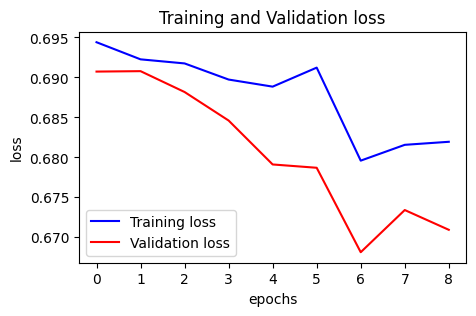

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = chrono_model.predict(X_test_cnn)
Y_pred_cnn = (pred_prob > 0.5).astype('int')

5/5 [==============================] - 2s 5ms/step


In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_cnn.reshape(-1), Y_pred_cnn.reshape(-1), rownames=['Actual label'], colnames=['Predicted label'])

Predicted label,0,1
Actual label,,
0,48,22
1,34,46


In [ ]:
# Creating a dictionary to store model performance metrics

chrono_mdl_3 = {}

chrono_mdl_3['Accuracy'] = round(accuracy_score(Y_test_cnn, Y_pred_cnn)*100)
chrono_mdl_3['Precision'] = round(precision_score(Y_test_cnn, Y_pred_cnn)*100)
chrono_mdl_3['Recall'] = round(recall_score(Y_test_cnn, Y_pred_cnn)*100)
chrono_mdl_3['F1_score'] = round(f1_score(Y_test_cnn, Y_pred_cnn)*100)

# Displaying the model performance metrics
chrono_mdl_3

{'Accuracy': 63, 'Precision': 68, 'Recall': 57, 'F1_score': 62}

## With Transformed Data: Short-term Fourier transform (STFT)

### Preparing the training data

In [ ]:
print('Shape of filtered trials[1.0]:', trials_filt[1.0].shape)
print('Shape of filtered trials[2.0]:', trials_filt[2.0].shape)

Shape of filtered trials[1.0]: (2, 500, 149)
Shape of filtered trials[2.0]: (2, 500, 157)


In [ ]:
# Reshaping the data

x_1 = np.moveaxis(trials_filt[1.0], 0,2)
x_1 = np.moveaxis(x_1, 0,1)

x_2 = np.moveaxis(trials_filt[2.0], 0,2)
x_2 = np.moveaxis(x_2, 0,1)

x_1.shape, x_2.shape

((149, 500, 2), (157, 500, 2))

In [ ]:
# Creating the training data
data_array = np.vstack((x_1, x_2))
data_array.shape

(306, 500, 2)

Performing STFT

In [ ]:
# STFT parameters
fs = sample_rate # Sampling frequency
nperseg = nsamples  # Length of each segment
noverlap = 32  # Overlap between segments

fs, nperseg, noverlap

(125, 500, 32)

In [ ]:
# Perform STFT for each channel
stft_results = []
for channel in range(data_array.shape[2]):  # Iterate over channels
    channel_data = data_array[:, :, channel]  # Extract data for each channel
    _, _, stft_data = stft(channel_data, fs=fs, nperseg=nperseg, noverlap=noverlap)
    stft_results.append(stft_data)

# Convert the results to a NumPy array
stft_results = np.array(stft_results)
stft_results.shape

# The shape of 'stft_results' will be (channels, trials, frequency_bins, time_bins)

(2, 306, 251, 3)

In [ ]:
# Reshaping the data

X_train_cnn = np.moveaxis(stft_results, 0,-1)
X_train_cnn.shape

# Now the data is in shape: trials * frequency_bins * time_bins * channels

(306, 251, 3, 2)

In [ ]:
# The two channels (C3 and C4) are stacked one below another to form a single image

X_train_cnn = X_train_cnn.reshape(306, -1, 3)
X_train_cnn.shape

(306, 502, 3)

In [ ]:
X_train_cnn.sum()

(-0.07398463151301729-0.042069224690892214j)

In [ ]:
# Converting the complex number into real by taking the magnitude

X_train_cnn = np.abs(X_train_cnn)

Data normalization is a best practice in deep learning, as it helps improve training stability, convergence speed, and the overall performance of CNN

In [ ]:
# Normalizing the data

min_value = np.min(X_train_cnn)
max_value = np.max(X_train_cnn)
X_train_cnn_nrm = (X_train_cnn - min_value) / (max_value - min_value)

X_train_cnn_nrm.min(), X_train_cnn_nrm.max()

(0.0, 1.0)

In [ ]:
# Getting train labels

Y_train_cnn.shape

(306, 1)

In [ ]:
np.unique(Y_train_cnn)

array([0, 1])

### Preparing the testing data

In [ ]:
# Original testing trials data

test_trials['Test'].shape

(2, 500, 150)

In [ ]:
# Reshaping the data

data_array = np.moveaxis(test_trials['Test'], 0,2)
data_array = np.moveaxis(data_array, 0,1)
data_array.shape

(150, 500, 2)

In [ ]:
# Perform STFT for each channel
stft_results = []
for channel in range(data_array.shape[2]):  # Iterate over channels
    channel_data = data_array[:, :, channel]  # Extract data for each channel
    _, _, stft_data = stft(channel_data, fs=fs, nperseg=nperseg, noverlap=noverlap)
    stft_results.append(stft_data)

# Convert the results to a NumPy array
stft_results = np.array(stft_results)
stft_results.shape

# The shape of 'stft_results' will be (channels, trials, frequency_bins, time_bins)

(2, 150, 251, 3)

In [ ]:
# Reshaping the data

X_test_cnn = np.moveaxis(stft_results, 0,-1)
X_test_cnn.shape

# Now the data is in shape: trials * frequency_bins * time_bins * channels

(150, 251, 3, 2)

In [ ]:
# The two channels (C3 and C4) are stacked one below another to form a single image

X_test_cnn = X_test_cnn.reshape(150, -1, 3)
X_test_cnn.shape

(150, 502, 3)

In [ ]:
X_test_cnn.sum()

(13.216857580825115+5.863533888125767j)

In [ ]:
# Converting the complex number into real by taking the magnitude

X_test_cnn = np.abs(X_test_cnn)

In [ ]:
# Normalizing the data

X_test_cnn_nrm = (X_test_cnn - min_value) / (max_value - min_value)

X_test_cnn_nrm.min(), X_test_cnn_nrm.max()

(0.0, 1.6314435859800842)

In [ ]:
# Getting test labels

Y_test_cnn.shape

(150, 1)

In [ ]:
np.unique(Y_test_cnn)

array([0, 1])

### Training the model

In [ ]:
# Getting the input shape

_, h, w = X_train_cnn.shape
h,w

(502, 3)

In [ ]:
# Deleting the previous instance of ChronoNet model
try:
  del chrono_model
except:
  pass

In [ ]:
# Creating the ChronoNet model

def block(input):
  conv1 = Conv1D(32, 2, strides=2,activation='relu',padding="same")(input)
  conv2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(input)
  conv3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(input)
  x = concatenate([conv1,conv2,conv3],axis=2)
  return x


ip_layer= Input(shape=(h, w))
block1=block(ip_layer)
block2=block(block1)
block3=block(block2)


gru_out1 = GRU(32,activation='tanh',return_sequences=True)(block3)
gru_out2 = GRU(32,activation='tanh',return_sequences=True)(gru_out1)
gru_out = concatenate([gru_out1,gru_out2],axis=2)
gru_out3 = GRU(32,activation='tanh',return_sequences=True)(gru_out)
gru_out = concatenate([gru_out1,gru_out2,gru_out3])
gru_out4 = GRU(32,activation='tanh')(gru_out)


op_layer = Dense(1, activation='sigmoid')(gru_out4)
chrono_model = Model(inputs=ip_layer, outputs=op_layer)

chrono_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 502, 3)]             0         []                            
                                                                                                  
 conv1d_71 (Conv1D)          (None, 251, 32)              224       ['input_5[0][0]']             
                                                                                                  
 conv1d_72 (Conv1D)          (None, 251, 32)              416       ['input_5[0][0]']             
                                                                                                  
 conv1d_73 (Conv1D)          (None, 251, 32)              800       ['input_5[0][0]']             
                                                                                            

In [ ]:
# Instantiating the ChronoNet model

chrono_model = Model(inputs=ip_layer, outputs=op_layer)
chrono_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 502, 3)]             0         []                            
                                                                                                  
 conv1d_71 (Conv1D)          (None, 251, 32)              224       ['input_5[0][0]']             
                                                                                                  
 conv1d_72 (Conv1D)          (None, 251, 32)              416       ['input_5[0][0]']             
                                                                                                  
 conv1d_73 (Conv1D)          (None, 251, 32)              800       ['input_5[0][0]']             
                                                                                            

In [ ]:
# hyper-parameters

epochs = 10
Optimizer = 'Adam'

In [ ]:
# Compiling the model

chrono_model.compile(optimizer=Optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
history = chrono_model.fit(X_train_cnn_nrm, Y_train_cnn,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_cnn_nrm, Y_test_cnn))

Epoch 1/10
10/10 [==============================] - 3s 354ms/step - loss: 0.6929 - accuracy: 0.5131 - val_loss: 0.6924 - val_accuracy: 0.5333 - lr: 1.0000e-04
Epoch 2/10
10/10 [==============================] - 3s 262ms/step - loss: 0.6929 - accuracy: 0.5131 - val_loss: 0.6924 - val_accuracy: 0.5333 - lr: 1.0000e-04
Epoch 3/10
10/10 [==============================] - 2s 203ms/step - loss: 0.6929 - accuracy: 0.5131 - val_loss: 0.6923 - val_accuracy: 0.5333 - lr: 1.0000e-04
Epoch 4/10
10/10 [==============================] - 2s 222ms/step - loss: 0.6929 - accuracy: 0.5131 - val_loss: 0.6923 - val_accuracy: 0.5333 - lr: 1.0000e-04
Epoch 5/10
10/10 [==============================] - 2s 203ms/step - loss: 0.6929 - accuracy: 0.5131 - val_loss: 0.6923 - val_accuracy: 0.5333 - lr: 1.0000e-04
Epoch 6/10
10/10 [==============================] - 2s 204ms/step - loss: 0.6929 - accuracy: 0.5131 - val_loss: 0.6923 - val_accuracy: 0.5333 - lr: 1.0000e-04


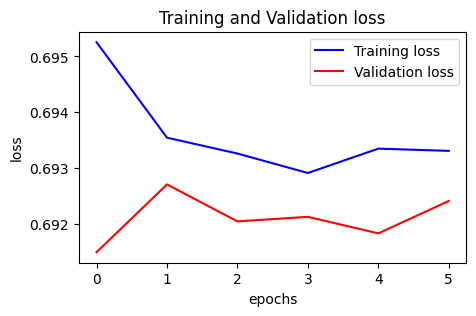

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = chrono_model.predict(X_test_cnn_nrm)
Y_pred_cnn = (pred_prob > 0.5).astype('int')

5/5 [==============================] - 0s 63ms/step


In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_cnn.reshape(-1), Y_pred_cnn.reshape(-1), rownames=['Actual label'], colnames=['Predicted label'])

Predicted label,1
Actual label,
0,70
1,80


In [ ]:
# Creating a dictionary to store model performance metrics

chrono_mdl_4 = {}

chrono_mdl_4['Accuracy'] = round(accuracy_score(Y_test_cnn, Y_pred_cnn)*100)
chrono_mdl_4['Precision'] = round(precision_score(Y_test_cnn, Y_pred_cnn)*100)
chrono_mdl_4['Recall'] = round(recall_score(Y_test_cnn, Y_pred_cnn)*100)
chrono_mdl_4['F1_score'] = round(f1_score(Y_test_cnn, Y_pred_cnn)*100)

# Displaying the model performance metrics
chrono_mdl_4

{'Accuracy': 53, 'Precision': 53, 'Recall': 100, 'F1_score': 70}

#### Optimal probability cut-off

In [ ]:
# Make predictions on the test set

y_pred_probabilities = model.predict(X_test_cnn_nrm)

5/5 [==============================] - 0s 16ms/step


In [ ]:
# Calculating sensitivity and specificity for different probability cut-offs

cut_off_prob = np.linspace(0,1,50)

sensitivity, specificity, TPR, FPR = opt_prob(cut_off_prob, Y_test_cnn.reshape(-1), y_pred_probabilities)

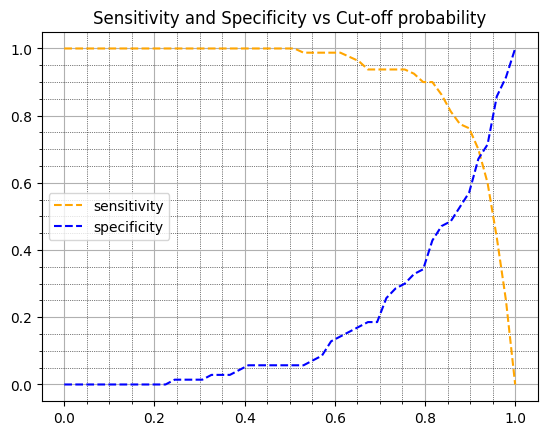

In [ ]:
# Plotting sensitivity and specificity to identify the optimal cut-off

sns.lineplot(x=cut_off_prob, y=sensitivity, color='orange', linestyle='--', label='sensitivity').minorticks_on()
sns.lineplot(x=cut_off_prob, y=specificity, color='blue', linestyle='--', label='specificity').grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title("Sensitivity and Specificity vs Cut-off probability")
plt.grid()
plt.show()

Optimal probability cutoff is ~0.9

In [ ]:
prob_cut_off = 0.9

# Convert probabilities to class labels
Y_pred_cnn = (y_pred_probabilities > prob_cut_off).astype(int)


np.unique(Y_pred_cnn)

array([0, 1])

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_cnn.reshape(-1), Y_pred_cnn.reshape(-1), rownames=['Actual label'], colnames=['Predicted label'])

Predicted label,0,1
Actual label,,
0,40,30
1,19,61


In [ ]:
# Creating a dictionary to store model performance metrics

chrono_mdl_4 = {}

chrono_mdl_4['Accuracy'] = round(accuracy_score(Y_test_cnn, Y_pred_cnn)*100)
chrono_mdl_4['Precision'] = round(precision_score(Y_test_cnn, Y_pred_cnn)*100)
chrono_mdl_4['Recall'] = round(recall_score(Y_test_cnn, Y_pred_cnn)*100)
chrono_mdl_4['F1_score'] = round(f1_score(Y_test_cnn, Y_pred_cnn)*100)

# Displaying the model performance metrics
chrono_mdl_4

{'Accuracy': 67, 'Precision': 67, 'Recall': 76, 'F1_score': 71}

**ChronoNet Models comparison**

In [ ]:
print("ChronoNet with raw data:", chrono_mdl_1)
print("ChronoNet with flitered data:", chrono_mdl_2)
print("ChronoNet with log-var transformed data:", chrono_mdl_3)
print("ChronoNet with STFT transformed data:", chrono_mdl_4)

ChronoNet with raw data: {'Accuracy': 47, 'Precision': 50, 'Recall': 69, 'F1_score': 58}
ChronoNet with flitered data: {'Accuracy': 50, 'Precision': 55, 'Recall': 34, 'F1_score': 42}
ChronoNet with log-var transformed data: {'Accuracy': 63, 'Precision': 68, 'Recall': 57, 'F1_score': 62}
ChronoNet with STFT transformed data: {'Accuracy': 67, 'Precision': 67, 'Recall': 76, 'F1_score': 71}


# ResNet Classifier (with Transfer Learning)

https://keras.io/api/applications/resnet/

## With Raw Data

### Preparing the training data

In [ ]:
# Original training trials data

print('Shape of trials[1.0]:', trials[1.0].shape)
print('Shape of trials[2.0]:', trials[2.0].shape)

Shape of trials[1.0]: (2, 500, 149)
Shape of trials[2.0]: (2, 500, 157)


ResNet expects data in shape 224x224x3, where 224x224 are image height & width and 3 is number of channels. Further, the height and width should be no smaller than 32.

Our EEG data has 1000(2x500) datapoints for each trial and the minimum needed is 1024(32x32). So we will append 24(12x2) zeros to reach the minimum required.

For channels, we will use the same datapoints across 3 channels

In [ ]:
# Reshaping the data

x_1 = np.moveaxis(trials[1.0], 0,2)
x_1 = np.moveaxis(x_1, 0,1)

x_2 = np.moveaxis(trials[2.0], 0,2)
x_2 = np.moveaxis(x_2, 0,1)

x_1.shape, x_2.shape

((149, 500, 2), (157, 500, 2))

In [ ]:
X_train_cnn = np.vstack((x_1, x_2))
X_train_cnn.shape

(306, 500, 2)

In [ ]:
X_train_cnn.sum()

17262.749669265988

In [ ]:
# Creating a array filled with zeros for the required shape
X_train_res = np.zeros((306, 512, 2, 3))

# Copy existing data into each channel of the new array
X_train_res[:, :500, :,0] = X_train_cnn
X_train_res[:, :500, :,1] = X_train_cnn
X_train_res[:, :500, :,2] = X_train_cnn

X_train_res.shape

(306, 512, 2, 3)

In [ ]:
# Reshaping to 32x32x3

X_train_res = X_train_res.reshape(306, 32, 32, 3)
X_train_res.shape

(306, 32, 32, 3)

In [ ]:
# Checking that we have same data in each channel

X_train_res[:,:,:,0].sum(), X_train_res[:,:,:,1].sum(), X_train_res[:,:,:,2].sum()

(17262.749669265984, 17262.749669265984, 17262.749669265984)

In [ ]:
# Minimum and Maximum values

X_train_res.min(), X_train_res.max()

(-35.289093, 40.392062)

Data normalization is a best practice in deep learning, as it helps improve training stability, convergence speed, and the overall performance of CNN

In [ ]:
# Normalizing the data

min_value = np.min(X_train_res)
max_value = np.max(X_train_res)
X_train_res_nrm = (X_train_res - min_value) / (max_value - min_value)

X_train_res_nrm.min(), X_train_res_nrm.max()

(0.0, 1.0)

In [ ]:
# Getting train labels

Y_train_res = Y_train_rf.reshape(Y_train_rf.shape[0], 1)
Y_train_res.shape

(306, 1)

In [ ]:
np.unique(Y_train_res)

array([1, 2])

As its a binary classifier, we will change the labels to 0 & 1

In [ ]:
# Re-mapping class labels

Y_train_res = Y_train_res - 1
np.unique(Y_train_res)

array([0, 1])

### Preparing the testing data

In [ ]:
# Original testing trials data

test_trials['Test'].shape

(2, 500, 150)

In [ ]:
# Reshaping the data

X_test_cnn = np.moveaxis(test_trials['Test'], 0,2)
X_test_cnn = np.moveaxis(X_test_cnn, 0,1)
X_test_cnn.shape

(150, 500, 2)

In [ ]:
# Creating a array filled with zeros for the required shape
X_test_res = np.zeros((150, 512, 2, 3))

# Copy existing data into each channel of the new array
X_test_res[:, :500, :,0] = X_test_cnn
X_test_res[:, :500, :,1] = X_test_cnn
X_test_res[:, :500, :,2] = X_test_cnn

X_test_res.shape

(150, 512, 2, 3)

In [ ]:
# Reshaping to 32x32x3

X_test_res = X_test_res.reshape(150, 32, 32, 3)
X_test_res.shape

(150, 32, 32, 3)

In [ ]:
# Normalizing the data

X_test_res_nrm = (X_test_res - min_value) / (max_value - min_value)

X_test_res_nrm.min(), X_test_res_nrm.max()

(-0.02227418437258256, 0.9885504654362105)

In [ ]:
# Getting test labels

Y_test_res = Y_test_rf.reshape(Y_test_rf.shape[0], 1)
Y_test_res.shape

(150, 1)

In [ ]:
np.unique(Y_test_res)

array([1, 2])

In [ ]:
# Re-mapping class labels

Y_test_res = Y_test_res - 1
np.unique(Y_test_res)

array([0, 1])

### Training the model

In [ ]:
# Getting the input shape

_, h, w, c = X_train_res.shape
h,w,c

(32, 32, 3)

In [ ]:
# Importing a pre-trained model without the final output layer

pretrained_model = ResNet50(input_shape=(h, w, c), include_top=False, weights='imagenet')

In [ ]:
# Creating new model by adding the output layer

res_model = keras.Sequential([pretrained_model,
                              Flatten(),
                              Dense(units=60, activation='relu'),
                              Dense(units=1, activation='sigmoid')])

res_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_14 (Dense)            (None, 60)                122940    
                                                                 
 dense_15 (Dense)            (None, 1)                 61        
                                                                 
Total params: 23710713 (90.45 MB)
Trainable params: 23657593 (90.25 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
# hyper-parameters

epochs = 10
Optimizer = 'Adam'

In [ ]:
# Compiling the model

res_model.compile(optimizer=Optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

This will take ~5mins

In [ ]:
history = res_model.fit(X_train_res, Y_train_res,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_res, Y_test_res))

Epoch 1/10
10/10 [==============================] - 47s 2s/step - loss: 1.1932 - accuracy: 0.4902 - val_loss: 27.3888 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 2/10
10/10 [==============================] - 19s 2s/step - loss: 0.7152 - accuracy: 0.6732 - val_loss: 4.4317 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 3/10
10/10 [==============================] - 20s 2s/step - loss: 0.5264 - accuracy: 0.8137 - val_loss: 23.3990 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 4/10
10/10 [==============================] - 19s 2s/step - loss: 0.4066 - accuracy: 0.8170 - val_loss: 4.2743 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 5/10
10/10 [==============================] - 20s 2s/step - loss: 0.3483 - accuracy: 0.8824 - val_loss: 0.6931 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 6/10
10/10 [==============================] - 19s 2s/step - loss: 0.2529 - accuracy: 0.9118 - val_loss: 3.7210 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 7/10
10/10 [==============================] - 19s 2s/step - loss: 0.1465 -

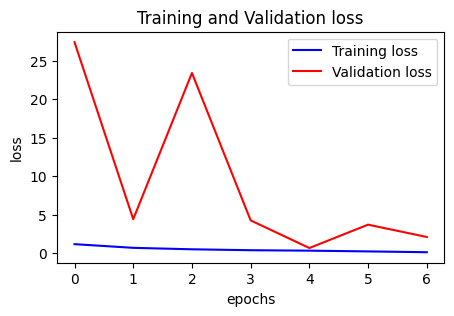

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = res_model.predict(X_test_res)
Y_pred_res = (pred_prob > 0.5).astype('int')

5/5 [==============================] - 2s 107ms/step


In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_res.reshape(-1), Y_pred_res.reshape(-1), rownames=['Actual label'], colnames=['Predicted label'])

Predicted label,0,1
Actual label,,
0,69,1
1,80,0


In [ ]:
# Creating a dictionary to store model performance metrics

res_mdl_1 = {}

res_mdl_1['Accuracy'] = round(accuracy_score(Y_test_res, Y_pred_res)*100)
res_mdl_1['Precision'] = round(precision_score(Y_test_res, Y_pred_res)*100)
res_mdl_1['Recall'] = round(recall_score(Y_test_res, Y_pred_res)*100)
res_mdl_1['F1_score'] = round(f1_score(Y_test_res, Y_pred_res)*100)

# Displaying the model performance metrics
res_mdl_1

{'Accuracy': 46, 'Precision': 0, 'Recall': 0, 'F1_score': 0}

#### Optimal probability cut-off

In [ ]:
# Make predictions on the test set

y_pred_probabilities = res_model.predict(X_test_res)

5/5 [==============================] - 1s 107ms/step


In [ ]:
# Calculating sensitivity and specificity for different probability cut-offs

cut_off_prob = np.linspace(0,1,50)

sensitivity, specificity, TPR, FPR = opt_prob(cut_off_prob, Y_test_cnn.reshape(-1), y_pred_probabilities)

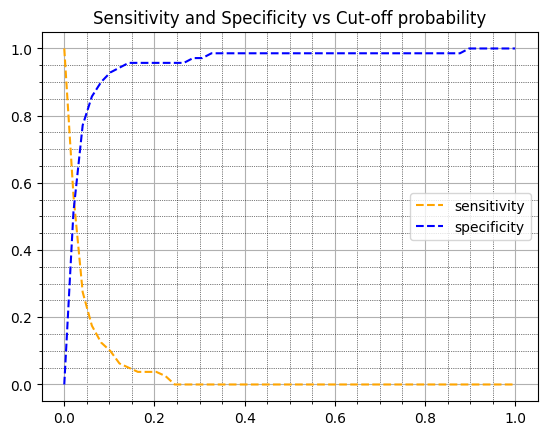

In [ ]:
# Plotting sensitivity and specificity to identify the optimal cut-off

sns.lineplot(x=cut_off_prob, y=sensitivity, color='orange', linestyle='--', label='sensitivity').minorticks_on()
sns.lineplot(x=cut_off_prob, y=specificity, color='blue', linestyle='--', label='specificity').grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title("Sensitivity and Specificity vs Cut-off probability")
plt.grid()
plt.show()

Optimal probability cutoff is ~0.8

In [ ]:
prob_cut_off = 0.8

# Convert probabilities to class labels
Y_pred_res = (y_pred_probabilities > prob_cut_off).astype(int)


np.unique(Y_pred_res)

array([1])

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_res.reshape(-1), Y_pred_res.reshape(-1), rownames=['Actual label'], colnames=['Predicted label'])

Predicted label,1
Actual label,
0,70
1,80


In [ ]:
# Calculating the performance metrics

print("Accuracy:", round(accuracy_score(Y_test_res, Y_pred_res)*100),"%")

print("\nPrecision:", round(precision_score(Y_test_res, Y_pred_res)*100),"%")

print("\nRecall:", round(recall_score(Y_test_res, Y_pred_res)*100),"%")

print("\nF1_score:", round(f1_score(Y_test_res, Y_pred_res)*100),"%")

Accuracy: 53 %

Precision: 53 %

Recall: 100 %

F1_score: 70 %


In [ ]:
res_mdl_1

{'Accuracy': 53, 'Precision': 53, 'Recall': 100, 'F1_score': 70}

## With Filtered Data (band-pass)

### Preparing the training data

In [ ]:
print('Shape of filtered trials[1.0]:', trials_filt[1.0].shape)
print('Shape of filtered trials[2.0]:', trials_filt[2.0].shape)

Shape of filtered trials[1.0]: (2, 500, 149)
Shape of filtered trials[2.0]: (2, 500, 157)


ResNet expects data in shape 224x224x3, where 224x224 are image height & width and 3 is number of channels. Further, the height and width should be no smaller than 32.

Our EEG data has 1000(2x500) datapoints for each trial and the minimum needed is 1024(32x32). So we will append 24(12x2) zeros to reach the minimum required.

For channels, we will use the same datapoints across 3 channels

In [ ]:
# Reshaping the data

x_1 = np.moveaxis(trials_filt[1.0], 0,2)
x_1 = np.moveaxis(x_1, 0,1)

x_2 = np.moveaxis(trials_filt[2.0], 0,2)
x_2 = np.moveaxis(x_2, 0,1)

x_1.shape, x_2.shape

((149, 500, 2), (157, 500, 2))

In [ ]:
X_train_cnn = np.vstack((x_1, x_2))
X_train_cnn.shape

(306, 500, 2)

In [ ]:
X_train_cnn.sum()

-65.90780677228926

In [ ]:
# Creating a array filled with zeros for the required shape
X_train_res = np.zeros((306, 512, 2, 3))

# Copy existing data into each channel of the new array
X_train_res[:, :500, :,0] = X_train_cnn
X_train_res[:, :500, :,1] = X_train_cnn
X_train_res[:, :500, :,2] = X_train_cnn

X_train_res.shape

(306, 512, 2, 3)

In [ ]:
# Reshaping to 32x32x3

X_train_res = X_train_res.reshape(306, 32, 32, 3)
X_train_res.shape

(306, 32, 32, 3)

In [ ]:
# Checking that we have same data in each channel

X_train_res[:,:,:,0].sum(), X_train_res[:,:,:,1].sum(), X_train_res[:,:,:,2].sum()

(-65.90780677228932, -65.90780677228932, -65.90780677228932)

In [ ]:
# Minimum and Maximum values

X_train_res.min(), X_train_res.max()

(-18.40416822978628, 17.588101355206373)

Data normalization is a best practice in deep learning, as it helps improve training stability, convergence speed, and the overall performance of CNN

In [ ]:
# Normalizing the data

min_value = np.min(X_train_res)
max_value = np.max(X_train_res)
X_train_res_nrm = (X_train_res - min_value) / (max_value - min_value)

X_train_res_nrm.min(), X_train_res_nrm.max()

(0.0, 1.0)

In [ ]:
# Getting train labels

Y_train_res.shape

(306, 1)

In [ ]:
np.unique(Y_train_res)

array([0, 1])

### Preparing the testing data

In [ ]:
# Raw Test Data
test_trials['Test'].shape

# Applying the band-pass filter
test_trials_filt = {'Test': bandpass(test_trials['Test'], 8, 15, sample_rate)}
test_trials_filt['Test'].shape

(2, 500, 150)

In [ ]:
# Reshaping the data

X_test_cnn = np.moveaxis(test_trials_filt['Test'], 0,2)
X_test_cnn = np.moveaxis(X_test_cnn, 0,1)
X_test_cnn.shape

(150, 500, 2)

In [ ]:
# Creating a array filled with zeros for the required shape
X_test_res = np.zeros((150, 512, 2, 3))

# Copy existing data into each channel of the new array
X_test_res[:, :500, :,0] = X_test_cnn
X_test_res[:, :500, :,1] = X_test_cnn
X_test_res[:, :500, :,2] = X_test_cnn

X_test_res.shape

(150, 512, 2, 3)

In [ ]:
# Reshaping to 32x32x3

X_test_res = X_test_res.reshape(150, 32, 32, 3)
X_test_res.shape

(150, 32, 32, 3)

In [ ]:
# Normalizing the data

X_test_res_nrm = (X_test_res - min_value) / (max_value - min_value)

X_test_res_nrm.min(), X_test_res_nrm.max()

(-0.03893295108946009, 1.0624754221575632)

In [ ]:
# Getting test labels

Y_test_res.shape

(150, 1)

In [ ]:
np.unique(Y_test_res)

array([0, 1])

### Training the model

In [ ]:
# Getting the input shape

_, h, w, c = X_train_res.shape
h,w,c

(32, 32, 3)

In [ ]:
# Importing a pre-trained model without the final output layer

pretrained_model = ResNet50(input_shape=(h, w, c), include_top=False, weights='imagenet')

In [ ]:
# Creating new model by adding the output layer

res_model = keras.Sequential([pretrained_model,
                              Flatten(),
                              Dense(units=60, activation='relu'),
                              Dense(units=1, activation='sigmoid')])

res_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 60)                122940    
                                                                 
 dense_11 (Dense)            (None, 1)                 61        
                                                                 
Total params: 23710713 (90.45 MB)
Trainable params: 23657593 (90.25 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
# hyper-parameters

epochs = 10
Optimizer = 'Adam'

In [ ]:
# Compiling the model

res_model.compile(optimizer=Optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

This will take ~5mins

In [ ]:
history = res_model.fit(X_train_res_nrm, Y_train_res,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_res_nrm, Y_test_res))

Epoch 1/10
10/10 [==============================] - 61s 2s/step - loss: 1.1670 - accuracy: 0.4771 - val_loss: 0.8626 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 2/10
10/10 [==============================] - 20s 2s/step - loss: 0.8264 - accuracy: 0.5294 - val_loss: 1.5480 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 3/10
10/10 [==============================] - 19s 2s/step - loss: 0.7559 - accuracy: 0.6013 - val_loss: 1.4913 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 4/10
10/10 [==============================] - 19s 2s/step - loss: 0.6436 - accuracy: 0.6078 - val_loss: 3.2823 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 5/10
10/10 [==============================] - 20s 2s/step - loss: 0.6145 - accuracy: 0.6830 - val_loss: 0.6931 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 6/10
10/10 [==============================] - 20s 2s/step - loss: 0.5670 - accuracy: 0.7026 - val_loss: 0.6931 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 7/10
10/10 [==============================] - 21s 2s/step - loss: 0.5662 - a

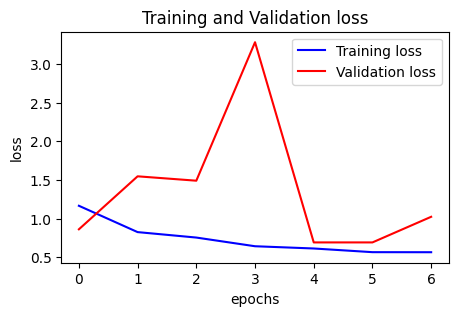

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = res_model.predict(X_test_res)
Y_pred_res = (pred_prob > 0.5).astype('int')

5/5 [==============================] - 2s 109ms/step


In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_res.reshape(-1), Y_pred_res.reshape(-1), rownames=['Actual label'], colnames=['Predicted label'])

Predicted label,0,1
Actual label,,
0,27,43
1,28,52


In [ ]:
# Creating a dictionary to store model performance metrics

res_mdl_2 = {}

res_mdl_2['Accuracy'] = round(accuracy_score(Y_test_res, Y_pred_res)*100)
res_mdl_2['Precision'] = round(precision_score(Y_test_res, Y_pred_res)*100)
res_mdl_2['Recall'] = round(recall_score(Y_test_res, Y_pred_res)*100)
res_mdl_2['F1_score'] = round(f1_score(Y_test_res, Y_pred_res)*100)

# Displaying the model performance metrics
res_mdl_2

{'Accuracy': 53, 'Precision': 55, 'Recall': 65, 'F1_score': 59}

#### Optimal probability cut-off

In [ ]:
# Make predictions on the test set

y_pred_probabilities = res_model.predict(X_test_res)

5/5 [==============================] - 1s 112ms/step


In [ ]:
# Calculating sensitivity and specificity for different probability cut-offs

cut_off_prob = np.linspace(0,1,50)

sensitivity, specificity, TPR, FPR = opt_prob(cut_off_prob, Y_test_cnn.reshape(-1), y_pred_probabilities)

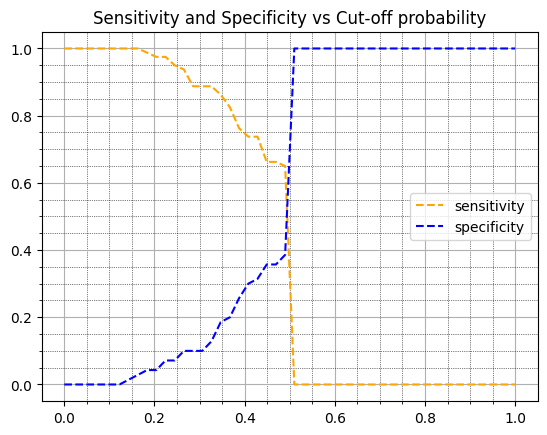

In [ ]:
# Plotting sensitivity and specificity to identify the optimal cut-off

sns.lineplot(x=cut_off_prob, y=sensitivity, color='orange', linestyle='--', label='sensitivity').minorticks_on()
sns.lineplot(x=cut_off_prob, y=specificity, color='blue', linestyle='--', label='specificity').grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title("Sensitivity and Specificity vs Cut-off probability")
plt.grid()
plt.show()

Optimal probability cutoff is ~0.25

In [ ]:
prob_cut_off = 0.25

# Convert probabilities to class labels
Y_pred_res = (y_pred_probabilities > prob_cut_off).astype(int)


np.unique(Y_pred_res)

array([0, 1])

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_res.reshape(-1), Y_pred_res.reshape(-1), rownames=['Actual label'], colnames=['Predicted label'])

Predicted label,0,1
Actual label,,
0,5,65
1,4,76


In [ ]:
# Calculating the performance metrics

print("Accuracy:", round(accuracy_score(Y_test_res, Y_pred_res)*100),"%")

print("\nPrecision:", round(precision_score(Y_test_res, Y_pred_res)*100),"%")

print("\nRecall:", round(recall_score(Y_test_res, Y_pred_res)*100),"%")

print("\nF1_score:", round(f1_score(Y_test_res, Y_pred_res)*100),"%")

Accuracy: 54 %

Precision: 54 %

Recall: 95 %

F1_score: 69 %


In [ ]:
res_mdl_2

{'Accuracy': 53, 'Precision': 55, 'Recall': 65, 'F1_score': 59}

## With Transformed Data (log-var)

### Preparing the training data

In [ ]:
print('Shape of log_var trials[1.0]:', trials_logvar[1.0].shape)
print('Shape of log_var trials[2.0]:', trials_logvar[2.0].shape)

Shape of log_var trials[1.0]: (2, 149)
Shape of log_var trials[2.0]: (2, 157)


ResNet expects data in shape 224x224x3, where 224x224 are image height & width and 3 is number of channels. Further, the height and width should be no smaller than 32.

Our EEG data has 2 datapoints for each trial and the minimum needed is 1024(32x32). So we will append 1022 zeros to reach the minimum required.

For channels, we will use the same datapoints across 3 channels

In [ ]:
# Reshaping the data

x_1 = np.moveaxis(trials_logvar[1.0], 0,1)

x_2 = np.moveaxis(trials_logvar[2.0], 0,1)

x_1.shape, x_2.shape

((149, 2), (157, 2))

In [ ]:
X_train_cnn = np.vstack((x_1, x_2))
X_train_cnn.shape

(306, 2)

In [ ]:
X_train_cnn.sum()

1088.4010978803585

In [ ]:
# Creating a array filled with zeros
X_train_res = np.zeros((306, 1024, 3))


# Copy existing data into each channel of the new array
for i in range(0, len(X_train_cnn)):
  X_train_res[i,:,0] = np.concatenate((X_train_cnn[i], np.zeros(1022)))
  X_train_res[i,:,1] = np.concatenate((X_train_cnn[i], np.zeros(1022)))
  X_train_res[i,:,2] = np.concatenate((X_train_cnn[i], np.zeros(1022)))


# Reshaping for the required shape
X_train_res = X_train_res.reshape(306,32,32,3)
X_train_res.shape

(306, 32, 32, 3)

In [ ]:
# Checking that we have same data in each channel

X_train_res[:,:,:,0].sum(), X_train_res[:,:,:,1].sum(), X_train_res[:,:,:,2].sum()

(1088.4010978803585, 1088.4010978803585, 1088.4010978803585)

In [ ]:
# Minimum and Maximum values

X_train_res.min(), X_train_res.max()

(-0.042490999112733505, 3.352244387965364)

Data normalization is a best practice in deep learning, as it helps improve training stability, convergence speed, and the overall performance of CNN

In [ ]:
# Normalizing the data

min_value = np.min(X_train_res)
max_value = np.max(X_train_res)
X_train_res_nrm = (X_train_res - min_value) / (max_value - min_value)

X_train_res_nrm.min(), X_train_res_nrm.max()

(0.0, 1.0)

In [ ]:
# Getting train labels

Y_train_res.shape

(306, 1)

In [ ]:
np.unique(Y_train_res)

array([0, 1])

### Preparing the testing data

In [ ]:
# Band-pass filtered Data
test_trials_filt['Test'].shape

(2, 500, 150)

In [ ]:
# Performing the log-var transformation
test_trials_logvar = {'Test': logvar(test_trials_filt['Test'])}
test_trials_logvar['Test'].shape

(2, 150)

In [ ]:
# Reshaping the data

X_test_cnn = np.moveaxis(test_trials_logvar['Test'], 0,1)
X_test_cnn.shape

(150, 2)

In [ ]:
# Creating a array filled with zeros
X_test_res = np.zeros((150, 1024, 3))


# Copy existing data into each channel of the new array
for i in range(0, len(X_test_cnn)):
  X_test_res[i,:,0] = np.concatenate((X_test_cnn[i], np.zeros(1022)))
  X_test_res[i,:,1] = np.concatenate((X_test_cnn[i], np.zeros(1022)))
  X_test_res[i,:,2] = np.concatenate((X_test_cnn[i], np.zeros(1022)))


# Reshaping for the required shape
X_test_res = X_test_res.reshape(150,32,32,3)
X_test_res.shape

(150, 32, 32, 3)

In [ ]:
# Normalizing the data

X_test_res_nrm = (X_test_res - min_value) / (max_value - min_value)

X_test_res_nrm.min(), X_test_res_nrm.max()

(-0.10642297425232002, 0.8907845642330797)

In [ ]:
# Getting test labels

Y_test_res.shape

(150, 1)

In [ ]:
np.unique(Y_test_res)

array([0, 1])

### Training the model

In [ ]:
# Getting the input shape

_, h, w, c = X_train_res.shape
h,w,c

(32, 32, 3)

In [ ]:
# Importing a pre-trained model without the final output layer

pretrained_model = ResNet50(input_shape=(h, w, c), include_top=False, weights='imagenet')

In [ ]:
# Creating new model by adding the output layer

res_model = keras.Sequential([pretrained_model,
                              Flatten(),
                              Dense(units=60, activation='relu'),
                              Dense(units=1, activation='sigmoid')])

res_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 60)                122940    
                                                                 
 dense_13 (Dense)            (None, 1)                 61        
                                                                 
Total params: 23710713 (90.45 MB)
Trainable params: 23657593 (90.25 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
# hyper-parameters

epochs = 10
Optimizer = 'Adam'

In [ ]:
# Compiling the model

res_model.compile(optimizer=Optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

This will take ~5mins

In [ ]:
history = res_model.fit(X_train_res, Y_train_res,
                    epochs=epochs, verbose=1, callbacks=callbacks,
                    validation_data=(X_test_res, Y_test_res))

Epoch 1/10
10/10 [==============================] - 42s 2s/step - loss: 0.9962 - accuracy: 0.5294 - val_loss: 13.2582 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 2/10
10/10 [==============================] - 20s 2s/step - loss: 0.8998 - accuracy: 0.5065 - val_loss: 27.5193 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 3/10
10/10 [==============================] - 20s 2s/step - loss: 0.7265 - accuracy: 0.5490 - val_loss: 100.2637 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 4/10
10/10 [==============================] - 19s 2s/step - loss: 0.7054 - accuracy: 0.5490 - val_loss: 12.3916 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 5/10
10/10 [==============================] - 20s 2s/step - loss: 0.6993 - accuracy: 0.5654 - val_loss: 21.0377 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 6/10
10/10 [==============================] - 19s 2s/step - loss: 0.6818 - accuracy: 0.5719 - val_loss: 4.4167 - val_accuracy: 0.4667 - lr: 0.0010


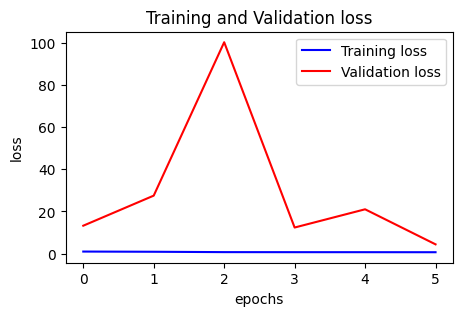

In [ ]:
# Loss vs Epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.figure(figsize=(5, 3))

plt.plot(epoch_range, loss, 'b', label='Training loss')
plt.plot(epoch_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")

plt.show()

### Testing the model

In [ ]:
# Make predictions
pred_prob = res_model.predict(X_test_res)
Y_pred_res = (pred_prob > 0.5).astype('int')

5/5 [==============================] - 2s 110ms/step


In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_res.reshape(-1), Y_pred_res.reshape(-1), rownames=['Actual label'], colnames=['Predicted label'])

Predicted label,0
Actual label,
0,70
1,80


In [ ]:
# Creating a dictionary to store model performance metrics

res_mdl_3 = {}

res_mdl_3['Accuracy'] = round(accuracy_score(Y_test_res, Y_pred_res)*100)
res_mdl_3['Precision'] = round(precision_score(Y_test_res, Y_pred_res)*100)
res_mdl_3['Recall'] = round(recall_score(Y_test_res, Y_pred_res)*100)
res_mdl_3['F1_score'] = round(f1_score(Y_test_res, Y_pred_res)*100)

# Displaying the model performance metrics
res_mdl_3

{'Accuracy': 47, 'Precision': 0, 'Recall': 0, 'F1_score': 0}

#### Optimal probability cut-off

In [ ]:
# Make predictions on the test set

y_pred_probabilities = res_model.predict(X_test_res)

5/5 [==============================] - 1s 144ms/step


In [ ]:
# Calculating sensitivity and specificity for different probability cut-offs

cut_off_prob = np.linspace(0,1,50)

sensitivity, specificity, TPR, FPR = opt_prob(cut_off_prob, Y_test_cnn.reshape(-1), y_pred_probabilities)

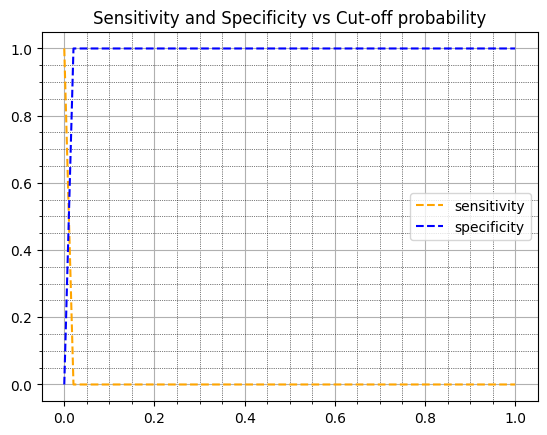

In [ ]:
# Plotting sensitivity and specificity to identify the optimal cut-off

sns.lineplot(x=cut_off_prob, y=sensitivity, color='orange', linestyle='--', label='sensitivity').minorticks_on()
sns.lineplot(x=cut_off_prob, y=specificity, color='blue', linestyle='--', label='specificity').grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title("Sensitivity and Specificity vs Cut-off probability")
plt.grid()
plt.show()

Optimal probability cutoff is ~0.4

In [ ]:
prob_cut_off = 0.4

# Convert probabilities to class labels
Y_pred_res = (y_pred_probabilities > prob_cut_off).astype(int)


np.unique(Y_pred_res)

array([0])

In [ ]:
# Making the Confusion Matrix

pd.crosstab(Y_test_res.reshape(-1), Y_pred_res.reshape(-1), rownames=['Actual label'], colnames=['Predicted label'])

Predicted label,0
Actual label,
0,70
1,80


In [ ]:
# Calculating the performance metrics

print("Accuracy:", round(accuracy_score(Y_test_res, Y_pred_res)*100),"%")

print("\nPrecision:", round(precision_score(Y_test_res, Y_pred_res)*100),"%")

print("\nRecall:", round(recall_score(Y_test_res, Y_pred_res)*100),"%")

print("\nF1_score:", round(f1_score(Y_test_res, Y_pred_res)*100),"%")

Accuracy: 47 %

Precision: 0 %

Recall: 0 %

F1_score: 0 %


In [ ]:
res_mdl_3

{'Accuracy': 47, 'Precision': 0, 'Recall': 0, 'F1_score': 0}

**ResNet Models comparison**

In [ ]:
print("ResNet with raw data:", res_mdl_1)
print("ResNet with flitered data:", res_mdl_2)
print("ResNet with transformed data:", res_mdl_3)

CNN with raw data: {'Accuracy': 53, 'Precision': 53, 'Recall': 100, 'F1_score': 70}
CNN with flitered data: {'Accuracy': 53, 'Precision': 55, 'Recall': 65, 'F1_score': 59}
CNN with transformed data: {'Accuracy': 47, 'Precision': 0, 'Recall': 0, 'F1_score': 0}


In [ ]:
print("ChronoNet with raw data:", chrono_mdl_1)
print("ChronoNet with flitered data:", chrono_mdl_2)
print("ChronoNet with transformed data:", chrono_mdl_3)

ChronoNet with raw data: {'Accuracy': 51, 'Precision': 53, 'Recall': 76, 'F1_score': 63}
ChronoNet with flitered data: {'Accuracy': 55, 'Precision': 56, 'Recall': 71, 'F1_score': 63}
ChronoNet with transformed data: {'Accuracy': 62, 'Precision': 63, 'Recall': 71, 'F1_score': 67}


In [ ]:
print("CNN with raw data:", cnn_mdl_1)
print("CNN with flitered data:", cnn_mdl_2)
print("CNN with transformed data:", cnn_mdl_3)

CNN with raw data: {'Accuracy': 51, 'Precision': 53, 'Recall': 68, 'F1_score': 60}
CNN with flitered data: {'Accuracy': 51, 'Precision': 55, 'Recall': 49, 'F1_score': 52}
CNN with transformed data: {'Accuracy': 62, 'Precision': 62, 'Recall': 75, 'F1_score': 68}
